### **Set up the working environment**

#### **Imports**

In [ ]:
!pip3 install pyro-ppl

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as grdsp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

import pyro
import pyro.distributions as dist
from pyro.contrib.bnn import HiddenLayer
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

#### **Working directories**

In [ ]:
base_dir = '/content/drive/MyDrive/PP'
data_dir = os.path.join(base_dir, 'Data')
plot_dir = os.path.join(base_dir, 'Plots')
models_dir = os.path.join(base_dir, 'Models')

#### **Plotting settings**

In [ ]:
import matplotlib.font_manager as fm

!wget "https://fonts.google.com/download?family=Open%20Sans" -O "/content/Open_Sans.zip"
!unzip "/content/Open_Sans.zip" -d "/content/Open_Sans"
!mv "/content/Open_Sans/" "/usr/share/fonts/truetype/Open_Sans/"
!rm "/content/Open_Sans.zip"
regular_font_path = '/usr/share/fonts/truetype/Open_Sans/OpenSans-Regular.ttf'
bold_font_path = '/usr/share/fonts/truetype/Open_Sans/OpenSans-Bold.ttf'

title_font = fm.FontProperties(fname=regular_font_path)
title_font.set_size(18)
title_font.set_style('normal')
titleL_font = fm.FontProperties(fname=regular_font_path)
titleL_font.set_size(32)
titleL_font.set_style('normal')
titleXL_font = fm.FontProperties(fname=regular_font_path)
titleXL_font.set_size(36)
titleXL_font.set_style('normal')

labels_font = fm.FontProperties(fname=regular_font_path)
labels_font.set_size(14)
labels_font.set_style('normal')
labelsB_font = fm.FontProperties(fname=bold_font_path)
labelsB_font.set_size(14)
labelsB_font.set_style('normal')

text_font = fm.FontProperties(fname=regular_font_path)
text_font.set_size(12)
text_font.set_style('normal')
textS_font = fm.FontProperties(fname=regular_font_path)
textS_font.set_size(10)
textS_font.set_style('normal')
textB_font = fm.FontProperties(fname=bold_font_path)
textB_font.set_size(12)
textB_font.set_style('normal')

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

class ColorScheme:
    def __init__(self):
        self.coral = '#f56958'
        self.yellow = '#f6e813'
        self.lilac = '#a051a0'
        self.cream = '#fef6e9'
        self.dark = '#1a1416'

class GradientColorMap:
    def __init__(self, colors: list):
        self.colors = colors
        self.name = 'gradient_cmap'
        self.num_bins = 100

    def get_cmap(self):
        cmap = LinearSegmentedColormap.from_list(self.name, self.colors, self.num_bins)
        return cmap
    
colors_ = ColorScheme()
gradient_map = GradientColorMap([colors_.dark + 'bf', colors_.coral])
plot_cmap = gradient_map.get_cmap()

# **Binary Classification**

### **Define utility functions**

In [ ]:
# Setting up GPU

use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [ ]:
# Define functions for train and evaluation

def train_dnn(model, train_loader, criterion, optimizer, epoch):
    train_loss = []
    train_acc = []

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        target = target.view_as(output)
        loss = criterion(output, target)
        loss.backward()
        train_loss.append(loss.data.numpy()) 
        
        predictions = (output > .5).float().squeeze()
        train_acc.append(predictions.eq(target.view_as(predictions)).float())

        optimizer.step()

    train_loss = np.array(train_loss).mean()
    train_acc  = torch.stack(train_acc, dim=0)
    train_acc = train_acc.mean()
    
    return train_loss, train_acc

def train_bnn(train_loader, svi, epoch):
    train_loss = []
    
    for batch_idx, (data, target) in enumerate(train_loader):  
        target = target.unsqueeze(dim=1)
        
        loss = svi.step(data, target)
        train_loss.append(loss) 

    train_loss = np.array(train_loss).mean()
    train_acc = evaluate_bnn(svi.guide, train_loader)

    return train_loss, train_acc


def evaluate_bnn(guide, data_loader, num_samples=8):
    accuracy = []

    for (data, target) in data_loader:
        ts = [pyro.poutine.trace(guide(None)).get_trace(data) for _ in range(num_samples)]
        predictions = [t.nodes['_RETURN']['value'].squeeze() for t in ts]
        predictions = torch.stack(predictions).mean(dim=0)
        predictions = (predictions > .5).float()

        accuracy.append(predictions.eq(target.view_as(predictions)).float())

    accuracy = torch.stack(accuracy, dim=0)
    b, s = accuracy.shape
    accuracy = accuracy.view(-1, b*s).mean()

    return accuracy

In [ ]:
# Function to compute classification performance stats

def compute_performance_dnn(model, test_loader): 

    true_labels = []
    pred_labels = []
    test_data = []

    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)

            true_labels.extend(target.detach().numpy())
            pred_labels.extend((output > .5).float().squeeze().detach().numpy())
            test_data.extend(data.detach().numpy())

    true_labels = np.array(true_labels).astype(int)
    pred_labels = np.array(pred_labels).astype(int)
    test_data = np.array(test_data)

    conf_matrix = confusion_matrix(true_labels, pred_labels)

    labels = ['0', '1']
    print(classification_report(true_labels, pred_labels,
                                target_names=labels))

    report = classification_report(true_labels, pred_labels,
                                   target_names=labels, output_dict=True)
    metrics_dict = {'true_labels': true_labels,
                    'pred_labels': pred_labels,
                    'test_data': test_data,
                    'accuracy': report['accuracy'],
                    'class_f1_score': [report[l]['f1-score'] for l in labels],
                    'conf_matrix': conf_matrix}

    return metrics_dict
    

def compute_performance_bnn(guide, data_loader, num_samples=8):

    true_labels = []
    pred_labels = []
    test_data = []    

    for (data, target) in data_loader:
        ts = [pyro.poutine.trace(guide(None)).get_trace(data) for _ in range(num_samples)]
        predictions = [t.nodes['_RETURN']['value'].squeeze() for t in ts]
        predictions = torch.stack(predictions).mean(dim=0)
        predictions = (predictions > .5).float()

        test_data.extend(data.numpy())
        true_labels.extend(target.numpy())
        pred_labels.extend(predictions.numpy())

    test_data = np.array(test_data)
    true_labels = np.array(true_labels).astype(int)
    pred_labels = np.array(pred_labels).astype(int)

    conf_matrix = confusion_matrix(true_labels, pred_labels)

    labels = ['0', '1']
    print(classification_report(true_labels, pred_labels,
                                target_names=labels))

    report = classification_report(true_labels, pred_labels,
                                   target_names=labels, output_dict=True)
    metrics_dict = {'true_labels': true_labels,
                    'pred_labels': pred_labels,
                    'test_data': test_data,
                    'accuracy': report['accuracy'],
                    'class_f1_score': [report[l]['f1-score'] for l in labels],
                    'conf_matrix': conf_matrix}

    return metrics_dict

In [ ]:
# Function to display the confusion matrix

def plot_confusion_matrix(ax, conf_matrix, title=None):

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    conf_img = ax.imshow(conf_matrix, cmap=plot_cmap, aspect='equal', )
    for idx_row, row in enumerate(conf_matrix):
        for idx_col, col in enumerate(row):
            y = idx_row
            x = idx_col
            ax.text(x, y, str(col), ha='center', va='center',
                    fontproperties=labelsB_font, color='white')

    xticks = []
    ax.set_xticks(xticks)
    yticks = []
    ax.set_yticks(yticks)

    labels = ['0', '1']
    for idx_label, label in enumerate(labels):
        vertical_x = -.55
        vertical_y = idx_label
        ax.text(vertical_x, vertical_y, label, ha='right', va='center',
                    fontproperties=labelsB_font, color=colors_.dark+'bf')
        
        horizontal_x = idx_label
        horizontal_y = -.55
        ax.text(horizontal_x, horizontal_y, label, ha='center', va='bottom',
                    fontproperties=labelsB_font, color=colors_.dark+'bf')

    if title is not None:
        ax.set_title('{:s}\n'.format(title.upper()), fontproperties=title_font,
                     color=colors_.dark+'bf')

In [ ]:
# Function to plot losses

def plot_loss(axis, bnn_loss, dnn_loss, plot_dict=None): 

    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)
    bg_color = colors_.dark + 'bf'
    axis.set_facecolor(bg_color) 

    bnn_plot = axis.plot(bnn_loss, color=colors_.cream, lw=.5)
    dnn_plot = axis.plot(dnn_loss, color=colors_.coral, lw=1)

    xlim = axis.get_xlim()
    axis.set_xticklabels([str(int(tick)) for tick in axis.get_xticks()],
                         fontproperties=text_font, color=bg_color)
    
    
    ylim = [int(min(bnn_loss.min(), dnn_loss.min())-.5),
            int(max(bnn_loss.max(), dnn_loss.max())+.5)]
    yticks = np.linspace(ylim[0], ylim[1], num=6, endpoint=True)
    axis.set_ylim([ylim[0]-1, ylim[1]+1]) 
    axis.set_yticks(yticks)
    axis.set_yticklabels([str('{:.2f}'.format(tick)) for tick in yticks],
                         fontproperties=text_font, color=bg_color)

    axis.tick_params(axis='both', color='black', length=3, width=.75)
    legend = axis.legend(['BNN loss', 'DNN loss'], prop=text_font, framealpha=.5)

In [ ]:
# Function to plot accuracies

def plot_accuracies(axis, bnn_acc, dnn_acc, plot_dict=None):  

    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)
    bg_color = colors_.dark + 'bf'
    axis.set_facecolor(bg_color) 
    
    bnn_plot = axis.plot(bnn_acc, color=colors_.cream, lw=.5)
    dnn_plot = axis.plot(dnn_acc, color=colors_.coral, lw=1)
    
    xlim = axis.get_xlim()    
    axis.set_xticklabels([str(int(tick)) for tick in axis.get_xticks()],
                         fontproperties=text_font, color=bg_color)
    
    ylim = [int(min(bnn_acc.min(), dnn_acc.min())),
            int(max(bnn_acc.max(), dnn_acc.max()))]
    yticks = np.linspace(ylim[0], ylim[1], num=6, endpoint=True)
    axis.set_ylim([ylim[0]-5, ylim[1]+5]) 
    axis.set_yticks(yticks)
    axis.set_yticklabels([str('{:.2f}'.format(tick)) for tick in yticks],
                         fontproperties=text_font, color=bg_color)

    axis.tick_params(axis='both', color='black', length=3, width=.75)
    legend = axis.legend(['BNN acc', 'DNN acc'], prop=text_font, framealpha=.5)

In [ ]:
# Function to display prior and posterior probability distributions

from scipy.stats import norm

def display_posterior_pdf(axis, param_name,
                          loc_post, scale_post,
                          prior_value=None, loc_prior=None, scale_prior=None,
                          inter_loc=None, inter_scale=None):   

    
    alphas = ['0d', '1a', '26', '33', '40', '4d', '59', '66', '73']     
    for idx, (l, s) in enumerate(zip(inter_loc, inter_scale)):
        sample_ = np.random.normal(loc=l, scale=s, size=1000)
        x_ = np.linspace(sample_.min(), sample_.max(), num=128, endpoint=True)
        pdf_ = norm.pdf(x_, loc=l, scale=s)

        inter_plot  = axis.plot(x_, pdf_, color=colors_.coral+alphas[idx], lw=1)
    
    sample_post = np.random.normal(loc=loc_post, scale=scale_post, size=1000)
    x_post = np.linspace(sample_post.min(), sample_post.max(), num=128, endpoint=True)
    pdf_post = norm.pdf(x_post, loc=loc_post, scale=scale_post)

    post_plot,  = axis.plot(x_post, pdf_post, color=colors_.coral, lw=1)
    legend_text = ['{:s} POSTERIOR'.format(param_name)]
    legend_h = [post_plot]

    if loc_prior is not None:
        sample_prior = np.random.normal(loc=loc_prior, scale=scale_prior, size=1000)
        x_prior = np.linspace(sample_prior.min(), sample_prior.max(), num=128, endpoint=True)
        pdf_prior = norm.pdf(x_prior, loc=loc_prior, scale=scale_prior)

        prior_plot, = axis.plot(x_prior, pdf_prior, color=colors_.cream, lw=1)        
        legend_text.append('{:s} PRIOR'.format(param_name))
        legend_h.append(prior_plot)
    
    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)
    axis.set_aspect('auto')
    bg_color = colors_.dark + 'bf'
    axis.set_facecolor(bg_color) 

    xlim = axis.get_xlim()
    axis.set_xticklabels(['{:.2f}'.format(tick) for tick in axis.get_xticks()],
                         fontproperties=textS_font, color=bg_color)
    ylim = [0, axis.get_ylim()[1]] 
    axis.set_ylim(ylim)
    yticks = np.linspace(ylim[0], ylim[1], 6)
    axis.set_yticks(yticks)
    axis.set_yticklabels(['{:.2f}'.format(tick) for tick in axis.get_yticks()],
                         fontproperties=textS_font, color=bg_color)

    axis.tick_params(axis='both', color=bg_color, length=3, width=.75)
    
    if prior_value is not None:
        sampled_weight, = axis.plot([prior_value, prior_value], ylim, 
                                    color=colors_.lilac, ls='--', lw=1.5)
        legend_text.append('prior {:s} = {:.2f}'.format(param_name.split('-')[1],
                                                        prior_value))
        legend_h.append(sampled_weight)
    
    axis.legend(legend_h, legend_text, prop=textS_font, framealpha=.5)
    title1 = 'Prior {:s}{:s}({:.2f}, {:.2f})'.format(param_name, '$\sim \mathcal{N}$', 
                                               loc_prior, scale_prior)
    title2 = 'Posterior {:s}{:s}({:.2f}, {:.2f})'.format(param_name, '$\sim \mathcal{N}$', 
                                               loc_post, scale_post)
    axis.set_title('{:s}\n{:s}'.format(title1, title2),
                   fontproperties=labels_font, color=bg_color)  

### **Data Processing**

In [ ]:
# Generate data

def generate_xor_data(num_samples):
    loc = np.array([[-1, -1],
                    [1, 1],
                    [-1, 1],
                    [1, -1]])
    scale = np.array([[.30, .30],
                      [.30, .30],
                      [.30, .30],
                      [.30, .30]])
    clusters = np.array([0, 0, 1, 1])

    num_clusters = len(clusters)
    labels = np.random.randint(0, num_clusters, size=num_samples)
    data = np.random.normal([loc[l] for l in labels], [scale[l] for l in labels], 
                            size=(num_samples, 2))
    labels = clusters[labels]

    return data, labels

def visualize_xor_data(ax, data, labels, title, 
                       colors=np.array([colors_.coral, colors_.cream])):   

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_aspect('equal')

    bg_color = colors_.dark + 'bf'
    ax.set_facecolor(bg_color)

    ticks = [-2, -1, 0, 1, 2]
    lims = [-3, 3]
    ax.set_xlim(lims)
    ax.set_xticks(ticks)
    ax.set_xticklabels(['{:d}'.format(t) for t in ticks], 
                       fontproperties=text_font, color=bg_color)
    ax.set_ylim(lims)
    ax.set_yticks(ticks)
    ax.set_yticklabels(['{:d}'.format(t) for t in ticks], 
                       fontproperties=text_font, color=bg_color)
    ax.tick_params(axis='both', color=bg_color, length=3, width=.75)
    
    # ax.vlines(0, ymin=-3, ymax=3, color=colors_.dark, lw=.35, ls='-.')
    # ax.hlines(0, xmin=-3, xmax=3, color=colors_.dark, lw=.35, ls='-.')

    xor_plot = ax.scatter(data[:, 0], data[:, 1], c=colors[labels], s=10, 
                          zorder=7)

    if title is not None:
        ax.set_title('{:s}'.format(title.upper()), fontproperties=title_font, 
                    color=bg_color)

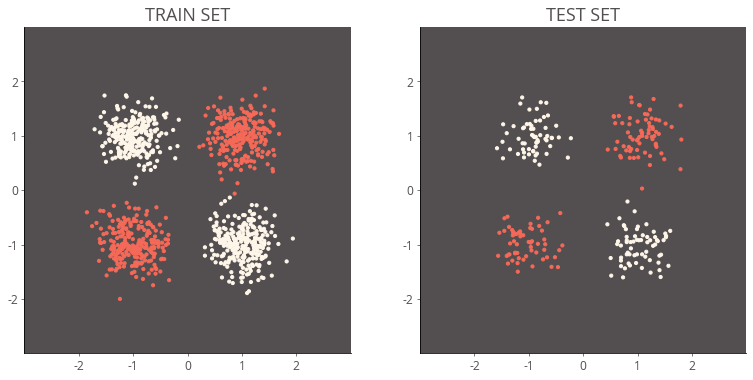

In [ ]:
# Create train and test sets

train_data, train_labels = generate_xor_data(1024)
test_data, test_labels = generate_xor_data(256)

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
visualize_xor_data(ax[0], train_data, train_labels, 'train set')
visualize_xor_data(ax[1], test_data, test_labels, 'test set')

In [ ]:
# Convert data to tensor

train_data, train_labels = map(torch.tensor, (train_data.astype(np.float32),
                                              train_labels.astype(np.float32)))
test_data, test_labels = map(torch.tensor, (test_data.astype(np.float32), 
                                            test_labels.astype(np.float32)))

print('Train Set : %4d samples - %s' % (len(train_data), str(train_data.shape)))
print(' Test Set : %4d samples - %s' % (len(test_data), str(test_data.shape)))

Train Set : 1024 samples - torch.Size([1024, 2])
 Test Set :  256 samples - torch.Size([256, 2])


In [ ]:
# Creating Dataloaders

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=128, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=128, drop_last=True)

print('Train batches : %d' % len(train_loader))
print(' Test batches : %d' % len(test_loader))

Train batches : 8
 Test batches : 2


### **Models**

In [ ]:
class DNN(nn.Module):
    def __init__(self, in_size, hid_size, out_size):
        super().__init__()

        self._fc1 = nn.Linear(in_size, hid_size)
        self._fc2 = nn.Linear(hid_size, out_size)

    def forward(self, x):

        x = self._fc1(x)
        x = F.relu(x)
        x = self._fc2(x)
        x = F.sigmoid(x)

        return x

In [ ]:
class BNN(nn.Module):
    def __init__(self, model_dnn, in_size, hid_size, out_size):
        super().__init__()

        self.in_size = in_size
        self.hid_size = hid_size
        self.out_size = out_size
        self.model_dnn = model_dnn

    def model_bnn(self, x, y=None):
        _fc1w_prior = dist.Normal(loc=torch.zeros(self.hid_size, self.in_size),
                                  scale=torch.ones(self.hid_size, self.in_size))
        _fc1b_prior = dist.Normal(loc=torch.zeros(self.hid_size),
                                  scale=torch.ones(self.hid_size))
        
        _fc2w_prior = dist.Normal(loc=torch.zeros(self.out_size, self.hid_size),
                                  scale=torch.ones(self.out_size, self.hid_size))
        _fc2b_prior = dist.Normal(loc=torch.zeros(self.out_size),
                                  scale=torch.ones(self.out_size))
        
        priors_dict = {'_fc1.weight': _fc1w_prior,
                       '_fc1.bias': _fc1b_prior,
                       '_fc2.weight': _fc2w_prior,
                       '_fc2.bias': _fc2b_prior}
                    
        sampled_module = pyro.random_module('module', self.model_dnn, priors_dict)  
        sampled_model = sampled_module()
        probs = sampled_model(x)

        obs = pyro.sample('obs', dist.Bernoulli(probs), obs=y)

    def guide_bnn(self, x, y=None):
        _fc1w_loc = pyro.param('_fc1w_loc', torch.randn(self.hid_size, self.in_size))
        _fc1w_scale = torch.abs(pyro.param('_fc1w_scale', torch.randn(self.hid_size, self.in_size)))
        _fc1w_posterior = dist.Normal(loc=_fc1w_loc, scale=_fc1w_scale)

        _fc1b_loc = pyro.param('_fc1b_loc', torch.randn(self.hid_size))
        _fc1b_scale = torch.abs(pyro.param('_fc1b_scale', torch.randn(self.hid_size)))
        _fc1b_posterior = dist.Normal(loc=_fc1b_loc, scale=_fc1b_scale)

        _fc2w_loc = pyro.param('_fc2w_loc', torch.randn(self.out_size, self.hid_size))
        _fc2w_scale = torch.abs(pyro.param('_fc2w_scale', torch.randn(self.out_size, self.hid_size)))
        _fc2w_posterior = dist.Normal(loc=_fc2w_loc, scale=_fc2w_scale)
        
        _fc2b_loc = pyro.param('_fc2b_loc', torch.randn(self.out_size))
        _fc2b_scale = torch.abs(pyro.param('_fc2b_scale', torch.randn(self.out_size)))
        _fc2b_posterior = dist.Normal(loc=_fc2b_loc, scale=_fc2b_scale)
        
        posteriors_dict = {'_fc1.weight': _fc1w_posterior,
                           '_fc1.bias': _fc1b_posterior,
                           '_fc2.weight': _fc2w_posterior,
                           '_fc2.bias': _fc2b_posterior}
        
        sampled_module = pyro.random_module('module', self.model_dnn, posteriors_dict) 
        
        return sampled_module()

In [ ]:
# Define parameters and Initialize model

model_dnn = DNN(2, 4, 1)

optimizer_dnn = torch.optim.Adam(model_dnn.parameters(),
                                 lr=.005, weight_decay=.01) 
criterion_dnn = nn.BCELoss()

model_bdnn = DNN(2, 4, 1)
bnn_ = BNN(model_bdnn, 2, 4, 1)

optimizer_bnn = pyro.optim.Adam({'lr': .01})
svi = SVI(bnn_.model_bnn, bnn_.guide_bnn, optimizer_bnn, loss=Trace_ELBO())

In [ ]:
# Training process

train_data_dnn = {'train_loss': [], 'train_acc': []}
train_data_bnn = {'train_loss': [], 'train_acc': []}

log_interval = 100
num_epochs = 1000

pyro.clear_param_store()
for epoch in range(num_epochs):

    train_loss_dnn, train_acc_dnn = train_dnn(model_dnn, train_loader, 
                                              criterion_dnn, optimizer_dnn, epoch)
    train_loss_bnn, train_acc_bnn = train_bnn(train_loader, svi, epoch)
    
    train_data_dnn['train_loss'].append(train_loss_dnn)
    train_data_dnn['train_acc'].append(train_acc_dnn)

    train_data_bnn['train_loss'].append(train_loss_bnn)
    train_data_bnn['train_acc'].append(train_acc_bnn)
    
    if epoch == 0:        
        inter_params_store = {key: [] for key in pyro.get_param_store()}

    if (epoch+1) % log_interval == 0 or epoch == 0 or (epoch+1) == num_epochs:
        print('\nEPOCH {:>2d}'.format(epoch+1))
        print('   DNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_dnn,
                                                               train_acc_dnn))
        print('   BNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_bnn,
                                                               train_acc_bnn))
        
        inter_ps =  pyro.get_param_store()
        for key, param in inter_ps.items():
            inter_params_store[key].append(param.detach().clone())


EPOCH  1
   DNN loss:    0.7529407   |   acc: 0.5224609
   BNN loss:  470.6844590   |   acc: 0.3359375

EPOCH 100
   DNN loss:    0.1316214   |   acc: 0.9775391
   BNN loss:   76.5872266   |   acc: 0.7402344

EPOCH 200
   DNN loss:    0.0849960   |   acc: 0.9912109
   BNN loss:   72.7137843   |   acc: 0.7167969

EPOCH 300
   DNN loss:    0.0882439   |   acc: 0.9951172
   BNN loss:   43.0901770   |   acc: 0.9970703

EPOCH 400
   DNN loss:    0.0882615   |   acc: 0.9951172
   BNN loss:   40.4529680   |   acc: 0.9951172

EPOCH 500
   DNN loss:    0.0882569   |   acc: 0.9951172
   BNN loss:   42.4273653   |   acc: 0.9960938

EPOCH 600
   DNN loss:    0.0882590   |   acc: 0.9951172
   BNN loss:   39.3174198   |   acc: 0.9970703

EPOCH 700
   DNN loss:    0.0882608   |   acc: 0.9951172
   BNN loss:   44.9561950   |   acc: 0.9960938

EPOCH 800
   DNN loss:    0.0882663   |   acc: 0.9951172
   BNN loss:   37.6099682   |   acc: 0.9980469

EPOCH 900
   DNN loss:    0.0882680   |   acc: 0.995117

In [ ]:
ps =  pyro.get_param_store()
bnn_params_store = dict()
for key, param in ps.items():
    bnn_params_store[key] = param.detach().clone()

### **Performance**

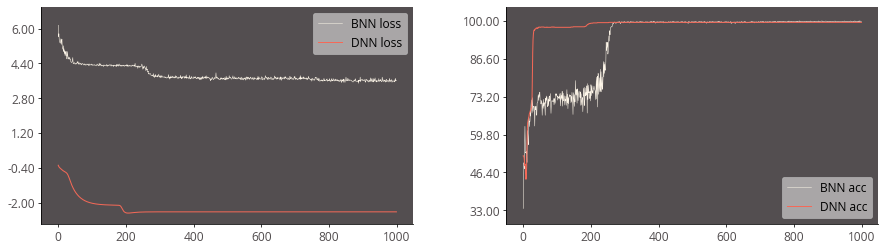

In [ ]:
# Display loss and accuracy

fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={'hspace': .5,
                                                          'wspace': .25})
  
train_loss_bnn = np.log(np.array(train_data_bnn['train_loss']))
train_loss_dnn = np.log(np.array(train_data_dnn['train_loss']))
plot_loss(ax[0], train_loss_bnn, train_loss_dnn)

train_acc_bnn = np.array(train_data_bnn['train_acc'])*100
train_acc_dnn = np.array(train_data_dnn['train_acc'])*100
plot_accuracies(ax[1], train_acc_bnn, train_acc_dnn)

In [ ]:
# Compute performance metrics

print('DEEP NEURAL NETWORK')
print('-' * 64)
metrics_dnn = compute_performance_dnn(model_dnn, test_loader)

print('\n\nBAYESIAN NEURAL NETWORK')
print('-' * 64)
metrics_bnn = compute_performance_bnn(bnn_.guide_bnn, test_loader)

DEEP NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       130
           1       1.00      1.00      1.00       126

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



BAYESIAN NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       130
           1       0.99      1.00      1.00       126

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



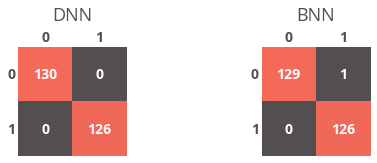

In [ ]:
# Display confusion matrix

fig, ax = plt.subplots(1, 2, figsize=(8, 2))

plot_confusion_matrix(ax[0], metrics_dnn['conf_matrix'], 'dnn')
plot_confusion_matrix(ax[1], metrics_bnn['conf_matrix'], 'bnn')

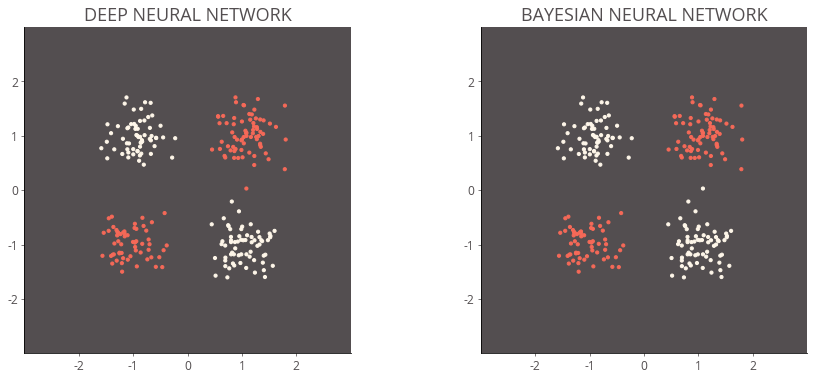

In [ ]:
# Display predictions for test data

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

visualize_xor_data(ax[0], metrics_dnn['test_data'], metrics_dnn['pred_labels'], 
                   'deep neural network')
visualize_xor_data(ax[1], metrics_bnn['test_data'], metrics_bnn['pred_labels'], 
                   'bayesian neural network')

## **Posterior distributions Analysis**

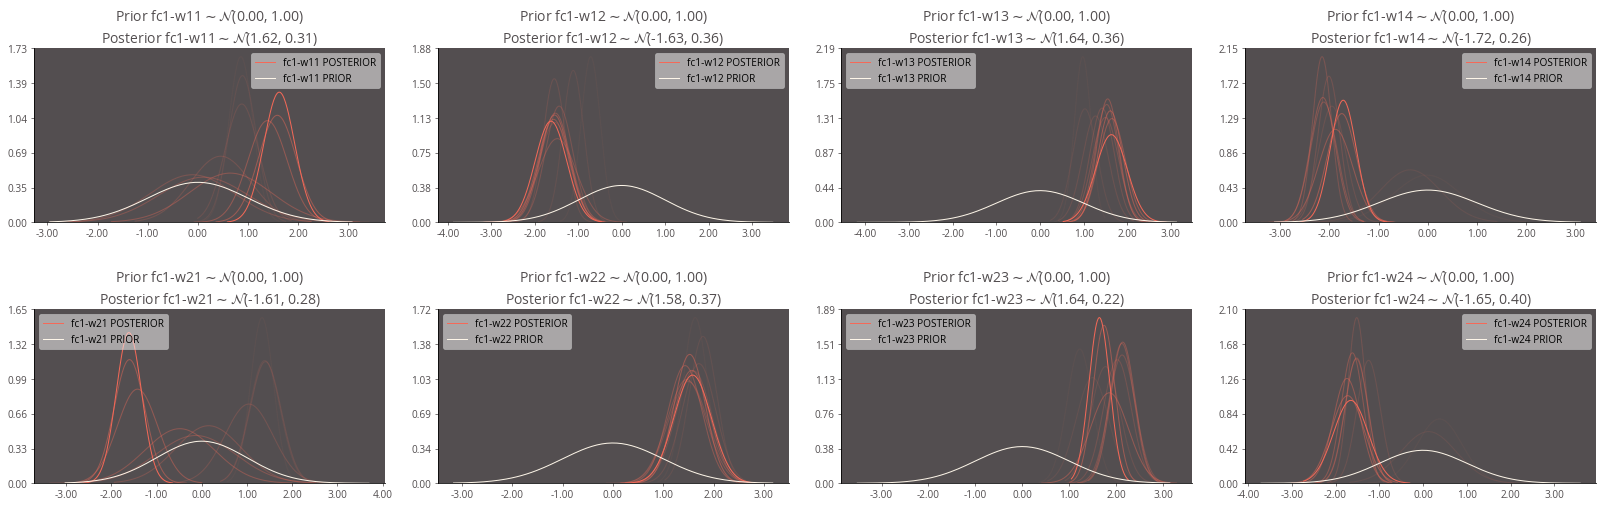

In [ ]:
# FC1 weights

fig, ax = plt.subplots(2, 4, figsize=(28, 8), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
w_loc = bnn_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(bnn_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        loc_prior, scale_prior = 0, 1
        prior_value = None

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row, col], param_name, loc_post, scale_post,
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

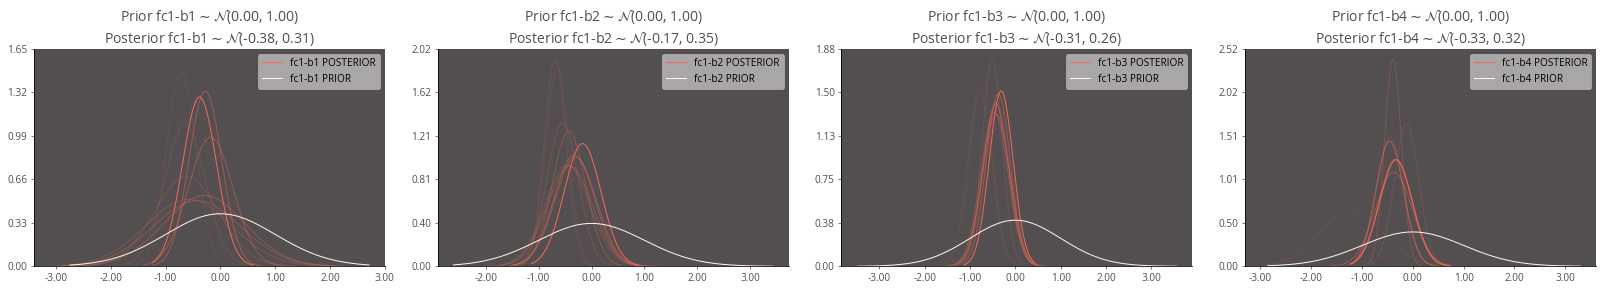

In [ ]:
# FC1 bias

fig, ax = plt.subplots(1, 4, figsize=(28, 4), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
b_loc = bnn_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(bnn_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
    loc_prior, scale_prior = 0, 1
    prior_value = None

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax[col], param_name, loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

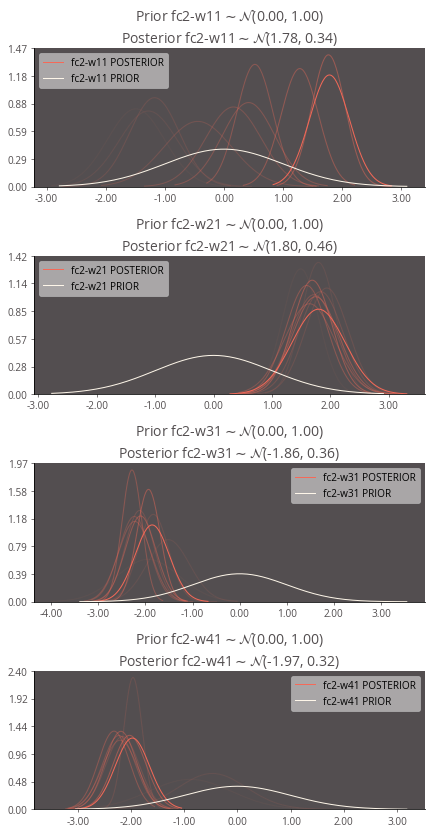

In [ ]:
# FC2 weights

fig, ax = plt.subplots(4, 1, figsize=(7, 14), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
w_loc = bnn_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(bnn_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        loc_prior, scale_prior = 0, 1
        prior_value = None

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row], param_name, loc_post, scale_post,
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

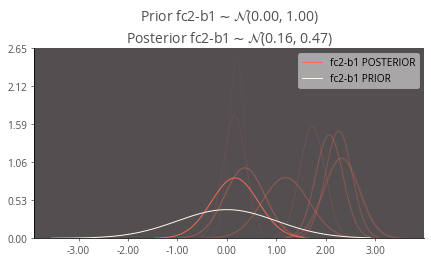

In [ ]:
# FC2 bias

fig, ax = plt.subplots(1, 1, figsize=(7, 3.5), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
b_loc = bnn_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(bnn_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
    loc_prior, scale_prior = 0, 1
    prior_value = None

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax, param_name, loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

### **Check DNN with weights sampled from the posterior distribution**

In [ ]:
def get_labels(data):
    fc1_weight = bnn_params_store['_fc1w_loc'].T
    fc1_bias = bnn_params_store['_fc1b_loc'].T

    fc2_weight = bnn_params_store['_fc2w_loc'].T
    fc2_bias = bnn_params_store['_fc2b_loc'].T

    labels = torch.matmul(data, fc1_weight) + fc1_bias
    labels = F.relu(labels)
    labels = torch.matmul(labels, fc2_weight) + fc2_bias
    labels = F.sigmoid(labels).squeeze()
    labels = (labels > .5).float()

    return labels

Accuracy 1.00


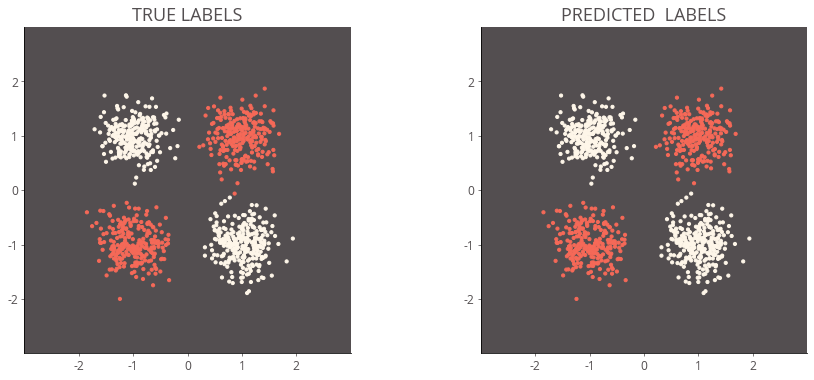

In [ ]:
predictions = get_labels(train_data)
acc = predictions.eq(train_labels.view_as(predictions)).float()
print('Accuracy {:.2f}'.format(acc.mean().item()))

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

visualize_xor_data(ax[0], train_data.numpy(), train_labels.numpy().astype(int), 'true labels')
visualize_xor_data(ax[1], train_data.numpy(), predictions.numpy().astype(int), 'predicted  labels')

# **Sanity Check 1**



Data labeled using the posterior distributions of the Bayesian network for weights and biases

> $\mu_{_{SC}} = \mu _{BNN_{posterior}}$  
> $\sigma_{_{SC}} = \sigma _{BNN_{posterior}}$  
> $w, b \sim \mathcal{N}(\mu_{_{SC}}, \sigma_{_{SC}})$



In [ ]:
# Function to label data for sanity check

def generate_labels(data):
    w1_loc = bnn_params_store['_fc1w_loc'].T.detach()
    w1_scale = torch.abs(bnn_params_store['_fc1w_scale']).T.detach()
    w1_dist = torch.distributions.Normal(loc=w1_loc, scale=w1_scale)
    fc1_weight  = []
    for _ in range(64):
        fc1_weight.append(w1_dist.sample())
    fc1_weight = torch.stack(fc1_weight).mean(dim=0)

    b1_loc = bnn_params_store['_fc1b_loc'].T.detach()
    b1_scale = torch.abs(bnn_params_store['_fc1b_scale']).T.detach()
    b1_dist = torch.distributions.Normal(loc=b1_loc, scale=b1_scale)
    fc1_bias = []
    for _ in range(64):
        fc1_bias.append(b1_dist.sample())
    fc1_bias = torch.stack(fc1_bias).mean(dim=0)
    
    w2_loc = bnn_params_store['_fc2w_loc'].T.detach()
    w2_scale = torch.abs(bnn_params_store['_fc2w_scale']).T.detach()
    w2_dist = torch.distributions.Normal(loc=w2_loc, scale=w2_scale)
    fc2_weight = []
    for _ in range(64):
        fc2_weight.append(w2_dist.sample())
    fc2_weight = torch.stack(fc2_weight).mean(dim=0)

    b2_loc = bnn_params_store['_fc2b_loc'].T.detach()
    b2_scale = torch.abs(bnn_params_store['_fc2b_scale']).T.detach()
    b2_dist = torch.distributions.Normal(loc=b2_loc, scale=b2_scale)
    fc2_bias = []
    for _ in range(64):
        fc2_bias.append(b2_dist.sample())
    fc2_bias = torch.stack(fc2_bias).mean(dim=0)

    labels = torch.matmul(data, fc1_weight) + fc1_bias
    labels = F.relu(labels)
    labels = torch.matmul(labels, fc2_weight) + fc2_bias
    labels = F.sigmoid(labels).squeeze()
    labels = (labels > .5).float()

    priors_dict = {'w1_loc': w1_loc, 'w1_scale': w1_scale,
                   'b1_loc': b1_loc, 'b1_scale': b1_scale,
                   'w2_loc': w2_loc, 'w2_scale': w2_scale,
                   'b2_loc': b2_loc, 'b2_scale': b2_scale}

    return priors_dict, fc1_weight, fc1_bias, fc2_weight, fc2_bias, labels

fc1_weight = 
 tensor([[ 1.6499, -1.5797,  1.5961, -1.7132],
        [-1.5893,  1.5057,  1.6308, -1.6149]])
fc1_bias = 
 tensor([-0.4076, -0.1179, -0.2524, -0.3601])
fc2_weight = 
 tensor([[ 1.7894],
        [ 1.8155],
        [-1.8934],
        [-1.9296]])
fc2_bias = 
 tensor([0.1177])



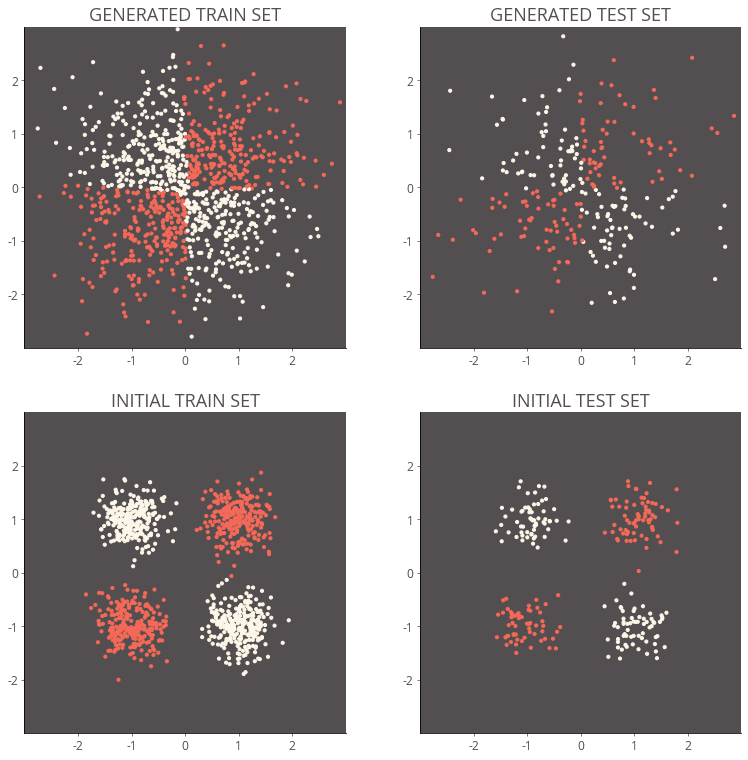

In [ ]:
# Generate train and test data for sanity check

sc_data = torch.randn(1280, 2)
sc_priors_dict, sc_fc1_weight, sc_fc1_bias, sc_fc2_weight, sc_fc2_bias, sc_labels = generate_labels(sc_data)
print('fc1_weight = \n', sc_fc1_weight)
print('fc1_bias = \n', sc_fc1_bias)
print('fc2_weight = \n', sc_fc2_weight)
print('fc2_bias = \n', sc_fc2_bias)
print()

sc_train_data, sc_train_labels = sc_data[:1024], sc_labels[:1024]
sc_test_data, sc_test_labels = sc_data[1024:], sc_labels[1024:]

fig, ax = plt.subplots(2, 2, figsize=(13, 13))
visualize_xor_data(ax[0, 0], sc_train_data, sc_train_labels.int(), 'generated train set')
visualize_xor_data(ax[0, 1], sc_test_data, sc_test_labels.int(), 'generated test set')
visualize_xor_data(ax[1, 0], train_data, train_labels.int(), 'initial train set')
visualize_xor_data(ax[1, 1], test_data, test_labels.int(), 'initial test set')

In [ ]:
# Creating Dataloaders

sc_train_dataset = TensorDataset(sc_train_data, sc_train_labels)
sc_test_dataset = TensorDataset(sc_test_data, sc_test_labels)

sc_train_loader = DataLoader(sc_train_dataset, batch_size=128, drop_last=True)
sc_test_loader = DataLoader(sc_test_dataset, batch_size=128, drop_last=True)

print('Train batches : %d' % len(sc_train_loader))
print(' Test batches : %d' % len(sc_test_loader))

Train batches : 8
 Test batches : 2


### **Models**

In [ ]:
class DNN(nn.Module):
    def __init__(self, in_size, hid_size, out_size):
        super().__init__()

        self._fc1 = nn.Linear(in_size, hid_size)
        self._fc2 = nn.Linear(hid_size, out_size)

    def forward(self, x):

        x = self._fc1(x)
        x = F.relu(x)
        x = self._fc2(x)
        x = F.sigmoid(x)

        return x

In [ ]:
class BNN(nn.Module):
    def __init__(self, model_dnn, in_size, hid_size, out_size):
        super().__init__()

        self.in_size = in_size
        self.hid_size = hid_size
        self.out_size = out_size
        self.model_dnn = model_dnn

    def model_bnn(self, x, y=None):
        w1_loc = bnn_params_store['_fc1w_loc']
        w1_scale = bnn_params_store['_fc1w_scale']
        _fc1w_prior = dist.Normal(loc=w1_loc,
                                  scale=torch.abs(w1_scale))
        
        
        b1_loc = bnn_params_store['_fc1b_loc']
        b1_scale = bnn_params_store['_fc1b_scale']
        _fc1b_prior = dist.Normal(loc=b1_loc,
                                  scale=torch.abs(b1_scale))
        

        w2_loc = bnn_params_store['_fc2w_loc']
        w2_scale = bnn_params_store['_fc2w_scale']
        _fc2w_prior = dist.Normal(loc=w2_loc,
                                  scale=torch.abs(w2_scale))
        
        b2_loc = bnn_params_store['_fc2b_loc']
        b2_scale = bnn_params_store['_fc2b_scale']
        _fc2b_prior = dist.Normal(loc=b2_loc,
                                  scale=torch.abs(b2_scale))
        
        priors_dict = {'_fc1.weight': _fc1w_prior,
                    '_fc1.bias': _fc1b_prior,
                    '_fc2.weight': _fc2w_prior,
                    '_fc2.bias': _fc2b_prior}
                    
        sampled_module = pyro.random_module('module', self.model_dnn, priors_dict)  
        sampled_model = sampled_module()
        probs = sampled_model(x)

        obs = pyro.sample('obs', dist.Bernoulli(probs), obs=y)

    def guide_bnn(self, x, y=None):
        _fc1w_loc = pyro.param('_fc1w_loc', torch.randn(self.hid_size, self.in_size))
        _fc1w_scale = torch.abs(pyro.param('_fc1w_scale', torch.randn(self.hid_size, self.in_size)))
        _fc1w_posterior = dist.Normal(loc=_fc1w_loc, scale=_fc1w_scale)

        _fc1b_loc = pyro.param('_fc1b_loc', torch.randn(self.hid_size))
        _fc1b_scale = torch.abs(pyro.param('_fc1b_scale', torch.randn(self.hid_size)))
        _fc1b_posterior = dist.Normal(loc=_fc1b_loc, scale=_fc1b_scale)

        _fc2w_loc = pyro.param('_fc2w_loc', torch.randn(self.out_size, self.hid_size))
        _fc2w_scale = torch.abs(pyro.param('_fc2w_scale', torch.randn(self.out_size, self.hid_size)))
        _fc2w_posterior = dist.Normal(loc=_fc2w_loc, scale=_fc2w_scale)
        
        _fc2b_loc = pyro.param('_fc2b_loc', torch.randn(self.out_size))
        _fc2b_scale = torch.abs(pyro.param('_fc2b_scale', torch.randn(self.out_size)))
        _fc2b_posterior = dist.Normal(loc=_fc2b_loc, scale=_fc2b_scale)
        
        posteriors_dict = {'_fc1.weight': _fc1w_posterior,
                    '_fc1.bias': _fc1b_posterior,
                    '_fc2.weight': _fc2w_posterior,
                    '_fc2.bias': _fc2b_posterior}
        
        sampled_module = pyro.random_module('module', self.model_dnn, posteriors_dict) 
        
        return sampled_module()

In [ ]:
# Define parameters and Initialize model

sc_model_dnn = DNN(2, 4, 1)

optimizer_dnn = torch.optim.Adam(sc_model_dnn.parameters(),
                                 lr=.0025, weight_decay=.01) 
criterion_dnn = nn.BCELoss()

sc_model_bdnn = DNN(2, 4, 1)
sc_bnn_ = BNN(sc_model_bdnn, 2, 4, 1)

optimizer_bnn = pyro.optim.Adam({'lr': .0025})
svi = SVI(sc_bnn_.model_bnn, sc_bnn_.guide_bnn, optimizer_bnn, loss=Trace_ELBO())

In [ ]:
# Training process

sc_train_data_dnn = {'train_loss': [], 'train_acc': []}
sc_train_data_bnn = {'train_loss': [], 'train_acc': []}

log_interval = 100
num_epochs = 1000

pyro.clear_param_store()
for epoch in range(num_epochs):

    train_loss_dnn, train_acc_dnn = train_dnn(sc_model_dnn, sc_train_loader, 
                                              criterion_dnn, optimizer_dnn, epoch)
    train_loss_bnn, train_acc_bnn = train_bnn(sc_train_loader, svi, epoch)
    
    sc_train_data_dnn['train_loss'].append(train_loss_dnn)
    sc_train_data_dnn['train_acc'].append(train_acc_dnn)

    sc_train_data_bnn['train_loss'].append(train_loss_bnn)
    sc_train_data_bnn['train_acc'].append(train_acc_bnn)

    if epoch == 0:        
        inter_params_store = {key: [] for key in pyro.get_param_store()}

    if (epoch+1) % log_interval == 0 or epoch == 0 or (epoch+1) == num_epochs:
        print('\nEPOCH {:>2d}'.format(epoch+1))
        print('   DNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_dnn,
                                                               train_acc_dnn))
        print('   BNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_bnn,
                                                               train_acc_bnn))
        
        inter_ps =  pyro.get_param_store()
        for key, param in inter_ps.items():
            inter_params_store[key].append(param.detach().clone())


EPOCH  1
   DNN loss:    0.7073945   |   acc: 0.4931641
   BNN loss:  312.4772949   |   acc: 0.5195312

EPOCH 100
   DNN loss:    0.3392115   |   acc: 0.9052734
   BNN loss:   72.6601978   |   acc: 0.8955078

EPOCH 200
   DNN loss:    0.2873095   |   acc: 0.9140625
   BNN loss:   31.6879361   |   acc: 0.9697266

EPOCH 300
   DNN loss:    0.2801314   |   acc: 0.9150391
   BNN loss:   34.1502811   |   acc: 0.9775391

EPOCH 400
   DNN loss:    0.2789482   |   acc: 0.9179688
   BNN loss:   32.2539465   |   acc: 0.9726562

EPOCH 500
   DNN loss:    0.2787666   |   acc: 0.9179688
   BNN loss:   32.1037285   |   acc: 0.9707031

EPOCH 600
   DNN loss:    0.2787383   |   acc: 0.9179688
   BNN loss:   32.3360708   |   acc: 0.9638672

EPOCH 700
   DNN loss:    0.2787330   |   acc: 0.9179688
   BNN loss:   34.4486473   |   acc: 0.9687500

EPOCH 800
   DNN loss:    0.2787327   |   acc: 0.9179688
   BNN loss:   31.5924994   |   acc: 0.9736328

EPOCH 900
   DNN loss:    0.2787326   |   acc: 0.917968

In [ ]:
ps =  pyro.get_param_store()
sc_params_store = dict()
for key, param in ps.items():
    sc_params_store[key] = param.detach().clone()

### **Performance**

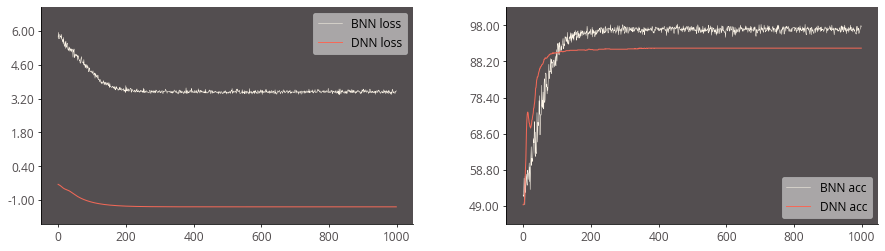

In [ ]:
# Display loss and accuracy

fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={'hspace': .5,
                                                          'wspace': .25})
  
train_loss_bnn = np.log(np.array(sc_train_data_bnn['train_loss']))
train_loss_dnn = np.log(np.array(sc_train_data_dnn['train_loss']))
plot_loss(ax[0], train_loss_bnn, train_loss_dnn)

train_acc_bnn = np.array(sc_train_data_bnn['train_acc'])*100
train_acc_dnn = np.array(sc_train_data_dnn['train_acc'])*100
plot_accuracies(ax[1], train_acc_bnn, train_acc_dnn)

In [ ]:
# Compute performance metrics

print('DEEP NEURAL NETWORK')
print('-' * 64)
sc_metrics_dnn = compute_performance_dnn(sc_model_dnn, sc_test_loader)

print('\n\nBAYESIAN NEURAL NETWORK')
print('-' * 64)
sc_metrics_bnn = compute_performance_bnn(sc_bnn_.guide_bnn, sc_test_loader)

DEEP NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       125
           1       0.87      0.95      0.91       131

    accuracy                           0.90       256
   macro avg       0.90      0.90      0.90       256
weighted avg       0.90      0.90      0.90       256



BAYESIAN NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.91      0.95       125
           1       0.92      0.98      0.95       131

    accuracy                           0.95       256
   macro avg       0.95      0.95      0.95       256
weighted avg       0.95      0.95      0.95       256



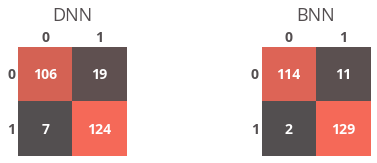

In [ ]:
# Display confusion matrix

fig, ax = plt.subplots(1, 2, figsize=(8, 2))

plot_confusion_matrix(ax[0], sc_metrics_dnn['conf_matrix'], 'dnn')
plot_confusion_matrix(ax[1], sc_metrics_bnn['conf_matrix'], 'bnn')

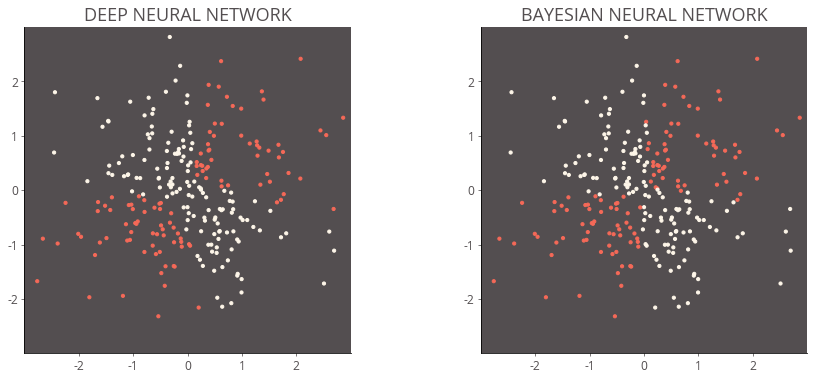

In [ ]:
# Display predictions for test data

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

visualize_xor_data(ax[0], sc_metrics_dnn['test_data'], sc_metrics_dnn['pred_labels'], 
                   'deep neural network')
visualize_xor_data(ax[1], sc_metrics_bnn['test_data'], sc_metrics_bnn['pred_labels'], 
                   'bayesian neural network')

## **Posterior distributions Analysis**

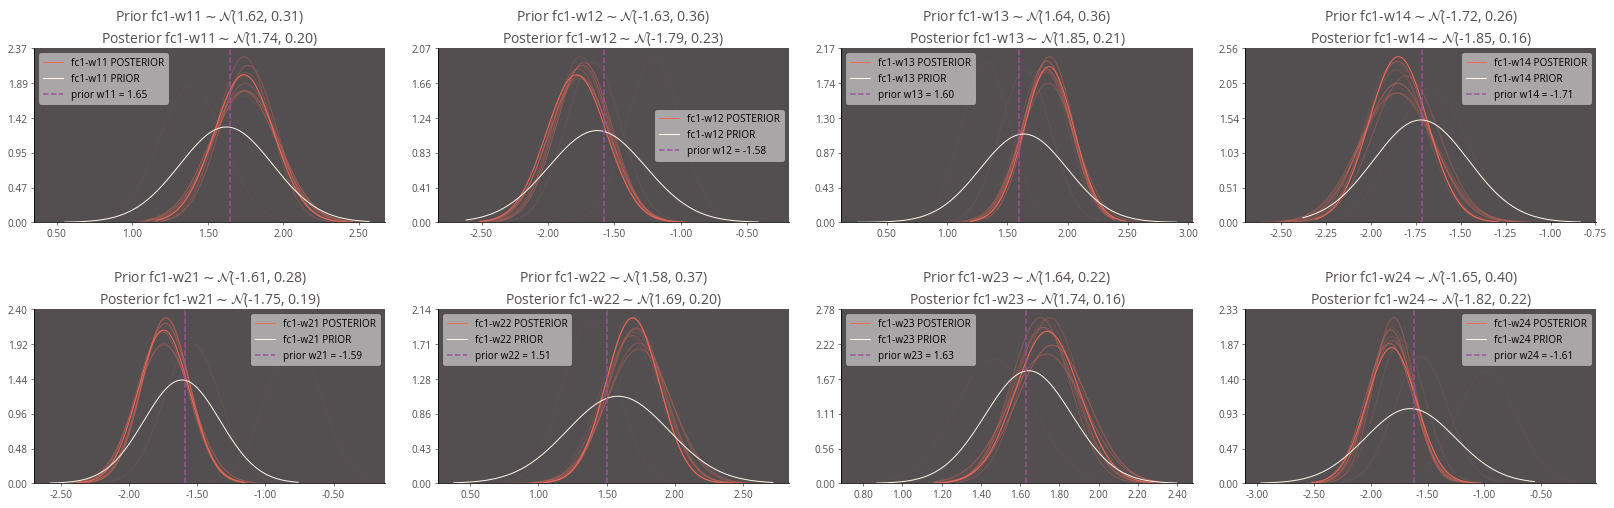

In [ ]:
# FC1 weight

fig, ax = plt.subplots(2, 4, figsize=(28, 8), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        
        prior_name = 'w{:s}'.format(layer[-1])
        loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col, row]
        scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col, row]
        prior_value = sc_fc1_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row, col], param_name, loc_post, scale_post,
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

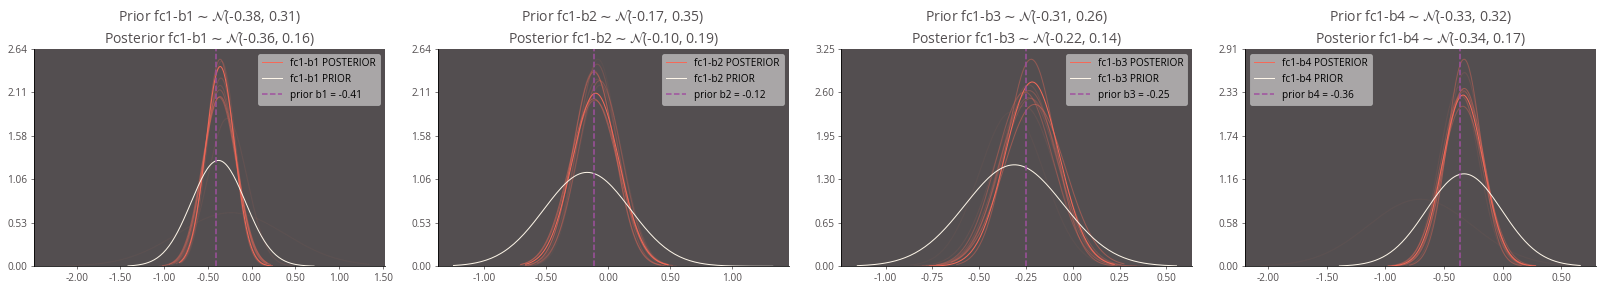

In [ ]:
# FC1 bias

fig, ax = plt.subplots(1, 4, figsize=(28, 4), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]

    prior_name = 'b{:s}'.format(layer[-1])
    loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col]
    scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col]
    prior_value = sc_fc1_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax[col], param_name, loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

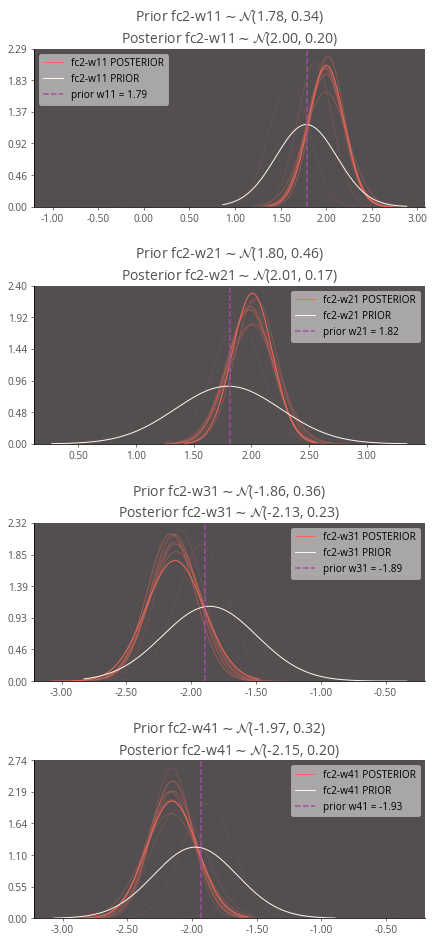

In [ ]:
# FC2 weight

fig, ax = plt.subplots(4, 1, figsize=(7, 16), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        
        prior_name = 'w{:s}'.format(layer[-1])
        loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col, row]
        scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col, row]
        prior_value = sc_fc2_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row], param_name, loc_post, scale_post,
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

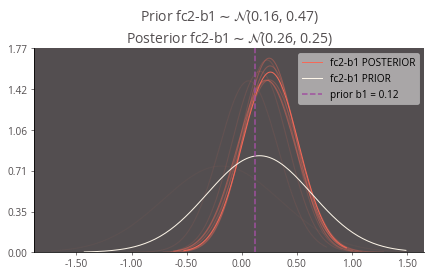

In [ ]:
# FC2 bias

fig, ax = plt.subplots(1, 1, figsize=(7, 3.75), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]

    prior_name = 'b{:s}'.format(layer[-1])
    loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col]
    scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col]
    prior_value = sc_fc2_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax, param_name, loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

# **Sanity Check 2**


Data labeled using random integer initialization in range $-1 .. 1$ for weights and zero biases

> $w = \overline{-1, 1}$  
> $b = 0$


In [ ]:
# Function to label data for sanity check

def generate_labels(data):
    fc1_weight = torch.randint(-1, 2, (4, 2)).float().T
    fc1_bias = torch.zeros(4)
    fc2_weight = torch.randint(-1, 2, (1, 4)).float().T
    fc2_bias = torch.zeros(1)

    labels = torch.matmul(data, fc1_weight) + fc1_bias
    labels = F.relu(labels)
    labels = torch.matmul(labels, fc2_weight) + fc2_bias
    labels = F.sigmoid(labels).squeeze()
    labels = (labels > .5).float()

    return fc1_weight, fc1_bias, fc2_weight, fc2_bias, labels

fc1_weight = 
 tensor([[-1., -1.,  0.,  0.],
        [ 0.,  0., -1.,  0.]])

fc1_bias = 
 tensor([0., 0., 0., 0.])

fc2_weight = 
 tensor([[ 0.],
        [ 1.],
        [-1.],
        [-1.]])

fc2_bias = 
 tensor([0.])


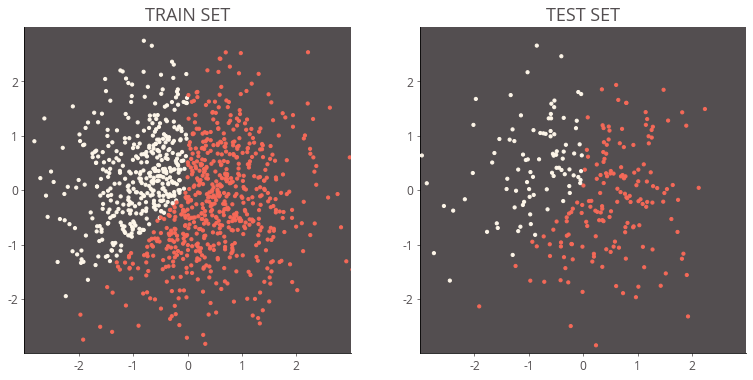

In [ ]:
# Generate train and test data for sanity check

sc_data = torch.randn(1280, 2)
sc_fc1_weight, sc_fc1_bias, sc_fc2_weight, sc_fc2_bias, sc_labels =\
 generate_labels(sc_data)

print('fc1_weight = \n', sc_fc1_weight)
print('\nfc1_bias = \n', sc_fc1_bias)
print('\nfc2_weight = \n', sc_fc2_weight)
print('\nfc2_bias = \n', sc_fc2_bias)

sc_train_data, sc_train_labels = sc_data[:1024], sc_labels[:1024]
sc_test_data, sc_test_labels = sc_data[1024:], sc_labels[1024:]
# print('Train Set : %4d samples - %s' % (len(sc_train_data), str(sc_train_data.shape)))
# print(' Test Set : %4d samples - %s' % (len(sc_test_data), str(sc_test_data.shape)))
# print('\n\n')

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
visualize_xor_data(ax[0], sc_train_data, sc_train_labels.int(), 'train set')
visualize_xor_data(ax[1], sc_test_data, sc_test_labels.int(), 'test set')

In [ ]:
# Creating Dataloaders

sc_train_dataset = TensorDataset(sc_train_data, sc_train_labels)
sc_test_dataset = TensorDataset(sc_test_data, sc_test_labels)

sc_train_loader = DataLoader(sc_train_dataset, batch_size=128, drop_last=True)
sc_test_loader = DataLoader(sc_test_dataset, batch_size=128, drop_last=True)

print('Train batches : %d' % len(sc_train_loader))
print(' Test batches : %d' % len(sc_test_loader))

Train batches : 8
 Test batches : 2


### **Models**

In [ ]:
class DNN(nn.Module):
    def __init__(self, in_size, hid_size, out_size):
        super().__init__()

        self._fc1 = nn.Linear(in_size, hid_size)
        self._fc2 = nn.Linear(hid_size, out_size)

    def forward(self, x):

        x = self._fc1(x)
        x = F.relu(x)
        x = self._fc2(x)
        x = F.sigmoid(x)

        return x

In [ ]:
class BNN(nn.Module):
    def __init__(self, model_dnn, in_size, hid_size, out_size):
        super().__init__()

        self.in_size = in_size
        self.hid_size = hid_size
        self.out_size = out_size
        self.model_dnn = model_dnn

    def model_bnn(self, x, y=None):
        _fc1w_prior = dist.Normal(loc=sc_fc1_weight.T,
                                  scale=torch.ones(self.hid_size, self.in_size))
        _fc1b_prior = dist.Normal(loc=sc_fc1_bias.T,
                                  scale=torch.ones(self.hid_size))
        
        _fc2w_prior = dist.Normal(loc=sc_fc2_weight.T,
                                  scale=torch.ones(self.out_size, self.hid_size))
        _fc2b_prior = dist.Normal(loc=sc_fc2_bias.T,
                                  scale=torch.ones(self.out_size))
        
        priors_dict = {'_fc1.weight': _fc1w_prior,
                    '_fc1.bias': _fc1b_prior,
                    '_fc2.weight': _fc2w_prior,
                    '_fc2.bias': _fc2b_prior}
                    
        sampled_module = pyro.random_module('module', self.model_dnn, priors_dict)  
        sampled_model = sampled_module()
        probs = sampled_model(x)

        obs = pyro.sample('obs', dist.Bernoulli(probs), obs=y)

    def guide_bnn(self, x, y=None):
        _fc1w_loc = pyro.param('_fc1w_loc', torch.randn(self.hid_size, self.in_size))
        _fc1w_scale = torch.abs(pyro.param('_fc1w_scale', torch.randn(self.hid_size, self.in_size)))
        _fc1w_posterior = dist.Normal(loc=_fc1w_loc, scale=_fc1w_scale)

        _fc1b_loc = pyro.param('_fc1b_loc', torch.randn(self.hid_size))
        _fc1b_scale = torch.abs(pyro.param('_fc1b_scale', torch.randn(self.hid_size)))
        _fc1b_posterior = dist.Normal(loc=_fc1b_loc, scale=_fc1b_scale)

        _fc2w_loc = pyro.param('_fc2w_loc', torch.randn(self.out_size, self.hid_size))
        _fc2w_scale = torch.abs(pyro.param('_fc2w_scale', torch.randn(self.out_size, self.hid_size)))
        _fc2w_posterior = dist.Normal(loc=_fc2w_loc, scale=_fc2w_scale)
        
        _fc2b_loc = pyro.param('_fc2b_loc', torch.randn(self.out_size))
        _fc2b_scale = torch.abs(pyro.param('_fc2b_scale', torch.randn(self.out_size)))
        _fc2b_posterior = dist.Normal(loc=_fc2b_loc, scale=_fc2b_scale)
        
        posteriors_dict = {'_fc1.weight': _fc1w_posterior,
                    '_fc1.bias': _fc1b_posterior,
                    '_fc2.weight': _fc2w_posterior,
                    '_fc2.bias': _fc2b_posterior}
        
        sampled_module = pyro.random_module('module', self.model_dnn, posteriors_dict) 
        
        return sampled_module()

In [ ]:
# Define parameters and Initialize model

sc_model_dnn = DNN(2, 4, 1)

optimizer_dnn = torch.optim.Adam(sc_model_dnn.parameters(),
                                 lr=.001, weight_decay=.01) 
criterion_dnn = nn.BCELoss()

sc_model_bdnn = DNN(2, 4, 1)
sc_bnn_ = BNN(sc_model_bdnn, 2, 4, 1)

optimizer_bnn = pyro.optim.Adam({'lr': .005})
svi = SVI(sc_bnn_.model_bnn, sc_bnn_.guide_bnn, optimizer_bnn, loss=Trace_ELBO())

In [ ]:
# Training process

sc_train_data_dnn = {'train_loss': [], 'train_acc': []}
sc_train_data_bnn = {'train_loss': [], 'train_acc': []}

log_interval = 100
num_epochs = 1000

pyro.clear_param_store()
for epoch in range(num_epochs):

    train_loss_dnn, train_acc_dnn = train_dnn(sc_model_dnn, sc_train_loader, 
                                              criterion_dnn, optimizer_dnn, epoch)
    train_loss_bnn, train_acc_bnn = train_bnn(sc_train_loader, svi, epoch)
    
    sc_train_data_dnn['train_loss'].append(train_loss_dnn)
    sc_train_data_dnn['train_acc'].append(train_acc_dnn)

    sc_train_data_bnn['train_loss'].append(train_loss_bnn)
    sc_train_data_bnn['train_acc'].append(train_acc_bnn)

    if epoch == 0:        
        inter_params_store = {key: [] for key in pyro.get_param_store()}

    if (epoch+1) % log_interval == 0 or epoch == 0 or (epoch+1) == num_epochs:
        print('\nEPOCH {:>2d}'.format(epoch+1))
        print('   DNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_dnn,
                                                               train_acc_dnn))
        print('   BNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_bnn,
                                                               train_acc_bnn))
        
        inter_ps =  pyro.get_param_store()
        for key, param in inter_ps.items():
            inter_params_store[key].append(param.detach().clone())


EPOCH  1
   DNN loss:    0.7131225   |   acc: 0.5117188
   BNN loss:  118.9630329   |   acc: 0.5986328

EPOCH 100
   DNN loss:    0.2810207   |   acc: 0.9472656
   BNN loss:   36.3104587   |   acc: 0.9746094

EPOCH 200
   DNN loss:    0.1743980   |   acc: 0.9345703
   BNN loss:   32.3123138   |   acc: 0.9833984

EPOCH 300
   DNN loss:    0.1568728   |   acc: 0.9355469
   BNN loss:   39.5605954   |   acc: 0.9736328

EPOCH 400
   DNN loss:    0.1522821   |   acc: 0.9355469
   BNN loss:   32.8354375   |   acc: 0.9843750

EPOCH 500
   DNN loss:    0.1504211   |   acc: 0.9375000
   BNN loss:   31.0361063   |   acc: 0.9736328

EPOCH 600
   DNN loss:    0.1488140   |   acc: 0.9384766
   BNN loss:   30.0495418   |   acc: 0.9785156

EPOCH 700
   DNN loss:    0.1106511   |   acc: 0.9687500
   BNN loss:   30.8889636   |   acc: 0.9785156

EPOCH 800
   DNN loss:    0.1004895   |   acc: 0.9785156
   BNN loss:   29.6137381   |   acc: 0.9873047

EPOCH 900
   DNN loss:    0.0970823   |   acc: 0.982421

In [ ]:
ps =  pyro.get_param_store()
sc_params_store = dict()
for key, param in ps.items():
    sc_params_store[key] = param.detach().clone()

### **Performance**

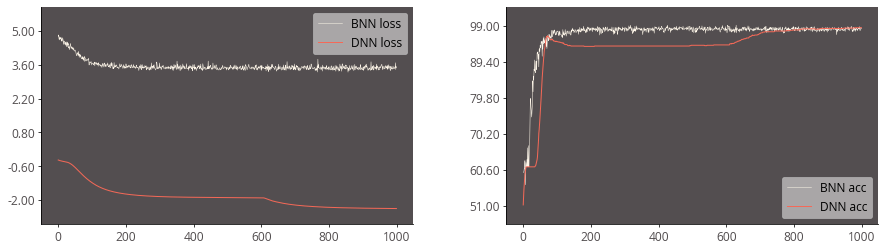

In [ ]:
# Display loss and accuracy

fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={'hspace': .5,
                                                          'wspace': .25})
  
train_loss_bnn = np.log(np.array(sc_train_data_bnn['train_loss']))
train_loss_dnn = np.log(np.array(sc_train_data_dnn['train_loss']))
plot_loss(ax[0], train_loss_bnn, train_loss_dnn)

train_acc_bnn = np.array(sc_train_data_bnn['train_acc'])*100
train_acc_dnn = np.array(sc_train_data_dnn['train_acc'])*100
plot_accuracies(ax[1], train_acc_bnn, train_acc_dnn)

In [ ]:
# Compute performance metrics

print('DEEP NEURAL NETWORK')
print('-' * 64)
sc_metrics_dnn = compute_performance_dnn(sc_model_dnn, sc_test_loader)

print('\n\nBAYESIAN NEURAL NETWORK')
print('-' * 64)
sc_metrics_bnn = compute_performance_bnn(sc_bnn_.guide_bnn, sc_test_loader)

DEEP NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       164
           1       0.97      0.97      0.97        92

    accuracy                           0.98       256
   macro avg       0.97      0.97      0.97       256
weighted avg       0.98      0.98      0.98       256



BAYESIAN NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       164
           1       0.97      0.95      0.96        92

    accuracy                           0.97       256
   macro avg       0.97      0.96      0.97       256
weighted avg       0.97      0.97      0.97       256



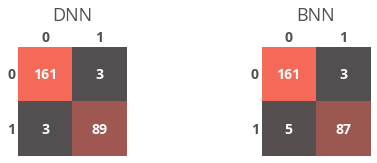

In [ ]:
# Display confusion matrix

fig, ax = plt.subplots(1, 2, figsize=(8, 2))

plot_confusion_matrix(ax[0], sc_metrics_dnn['conf_matrix'], 'dnn')
plot_confusion_matrix(ax[1], sc_metrics_bnn['conf_matrix'], 'bnn')

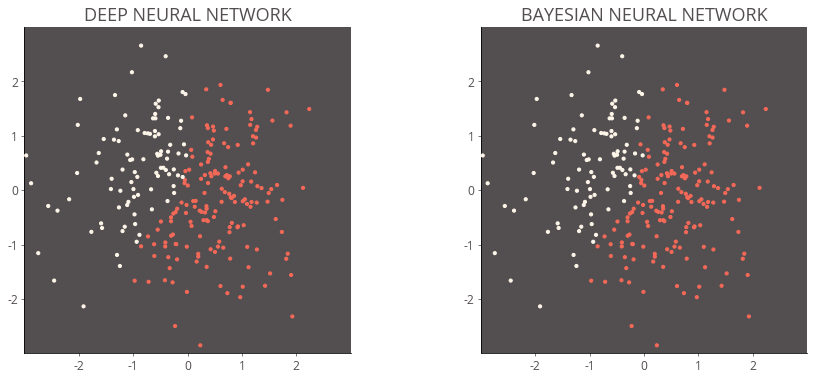

In [ ]:
# Display predictions for test data

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

visualize_xor_data(ax[0], sc_metrics_dnn['test_data'], sc_metrics_dnn['pred_labels'], 
                   'deep neural network')
visualize_xor_data(ax[1], sc_metrics_bnn['test_data'], sc_metrics_bnn['pred_labels'], 
                   'bayesian neural network')

## **Posterior distributions Analysis**

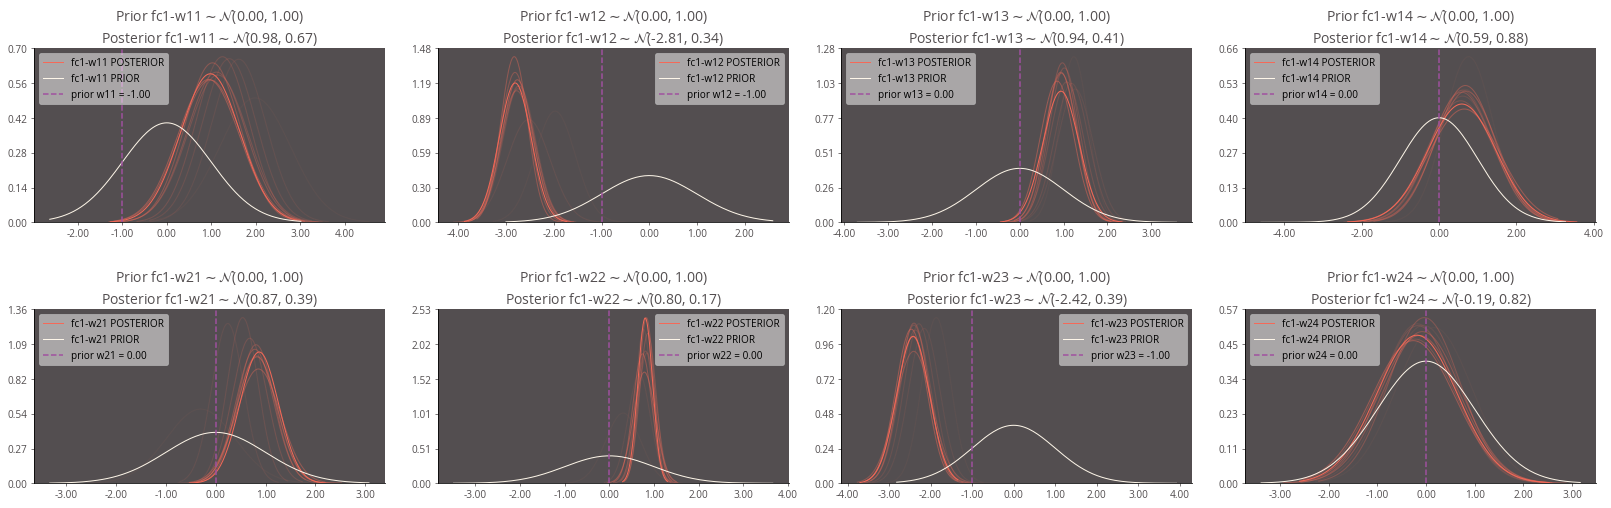

In [ ]:
# FC1 weight

fig, ax = plt.subplots(2, 4, figsize=(28, 8), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        loc_prior, scale_prior = 0, 1
        prior_value = sc_fc1_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row, col], param_name, 
                              loc_post, scale_post,
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

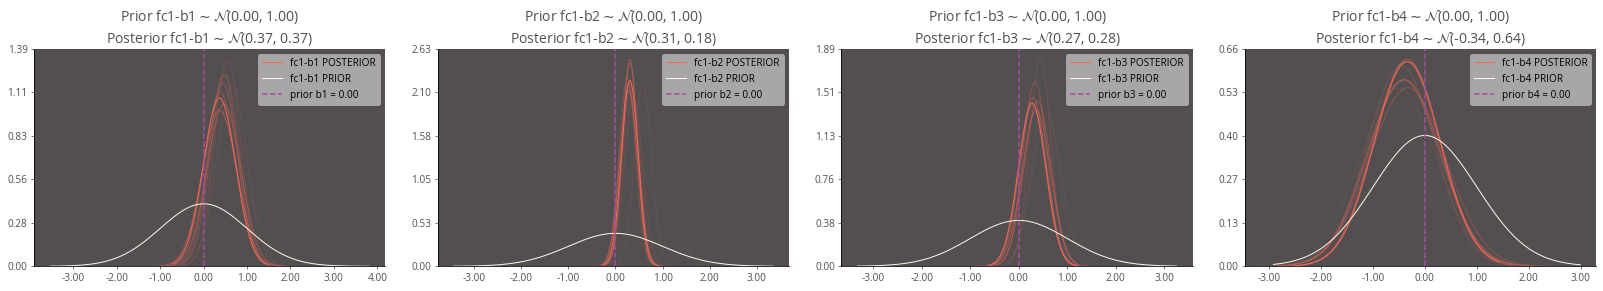

In [ ]:
# FC1 bias

fig, ax = plt.subplots(1, 4, figsize=(28, 4), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
    loc_prior, scale_prior = 0, 1
    prior_value = sc_fc1_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax[col], param_name, 
                          loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

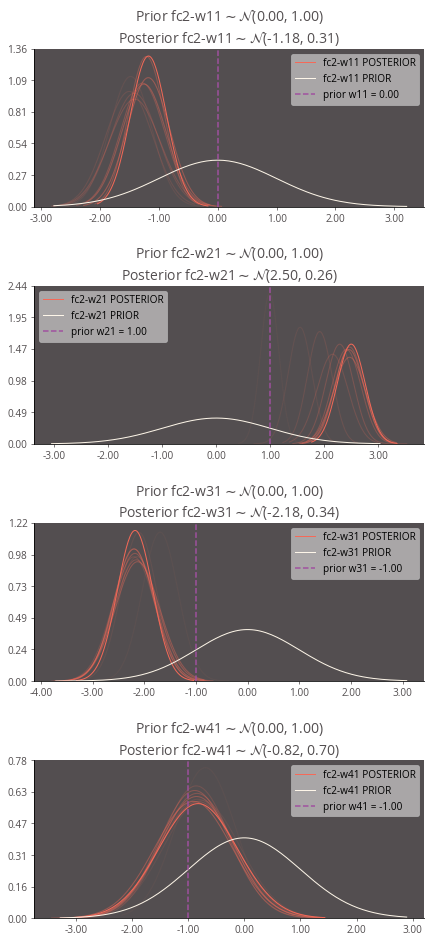

In [ ]:
# FC2 weight

fig, ax = plt.subplots(4, 1, figsize=(7, 16), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        loc_prior, scale_prior = 0, 1
        prior_value = sc_fc2_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row], param_name, 
                              loc_post, scale_post,
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

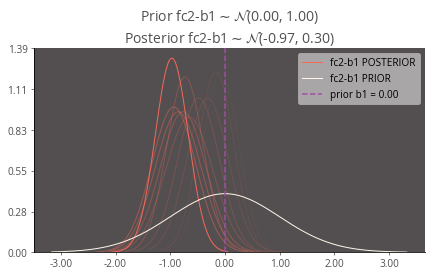

In [ ]:
# FC2 bias

fig, ax = plt.subplots(1, 1, figsize=(7, 3.75), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
    loc_prior, scale_prior = 0, 1
    prior_value = sc_fc2_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax, param_name, 
                          loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

# **Sanity Check 3**


Data labeled using random initialization for the weights and biases distributions parameters (average of repeated sampling)

> $\mu_{_{SC}} \sim \mathcal{N}(0, 1)$  
> $\sigma_{_{SC}} \sim \mathcal{N}(0, 1)$  
> $w, b \sim \mathcal{N}(\mu_{_{SC}}, \sigma_{_{SC}})$



In [ ]:
# Generate sanity-check data

def generate_labels(data):
    w1_loc = torch.randn(4, 2).float().T
    w1_scale = torch.abs(torch.randn(4, 2).float().T)
    w1_dist = torch.distributions.Normal(loc=w1_loc, scale=w1_scale)
    fc1_weight = []
    for _ in range(64):
        fc1_weight.append(w1_dist.sample())
    fc1_weight = torch.stack(fc1_weight)
    fc1_weight = fc1_weight.mean(dim=0)

    b1_loc = torch.randn(4).float()
    b1_scale = torch.abs(torch.randn(4).float())
    b1_dist = torch.distributions.Normal(loc=b1_loc, scale=b1_scale)
    fc1_bias = []
    for _ in range(64):
        fc1_bias.append(b1_dist.sample())
    fc1_bias = torch.stack(fc1_bias)
    fc1_bias = fc1_bias.mean(dim=0)
    
    w2_loc = torch.randn(1, 4).float().T
    w2_scale = torch.abs(torch.randn(1, 4).float().T)
    w2_dist = torch.distributions.Normal(loc=w2_loc, scale=w2_scale)
    fc2_weight = []
    for _ in range(64):
        fc2_weight.append(w2_dist.sample())
    fc2_weight = torch.stack(fc2_weight)
    fc2_weight = fc2_weight.mean(dim=0)

    b2_loc = torch.randn(1).float()
    b2_scale = torch.abs(torch.randn(1).float())
    b2_dist = torch.distributions.Normal(loc=b2_loc, scale=b2_scale)
    fc2_bias = []
    for _ in range(64):
        fc2_bias.append(b2_dist.sample())
    fc2_bias = torch.stack(fc2_bias)
    fc2_bias = fc2_bias.mean(dim=0)

    labels = torch.matmul(data, fc1_weight) + fc1_bias
    labels = F.relu(labels)
    labels = torch.matmul(labels, fc2_weight) + fc2_bias
    labels = F.sigmoid(labels).squeeze()
    labels = (labels > .5).float()

    priors_dict = {'w1_loc': w1_loc, 'w1_scale': w1_scale,
                   'b1_loc': b1_loc, 'b1_scale': b1_scale,
                   'w2_loc': w2_loc, 'w2_scale': w2_scale,
                   'b2_loc': b2_loc, 'b2_scale': b2_scale}

    return priors_dict, fc1_weight, fc1_bias, fc2_weight, fc2_bias, labels

fc1_weight = 
 tensor([[ 1.5696, -1.3461, -0.3861,  0.7369],
        [ 0.7791, -0.6271,  0.3857,  0.1486]])

fc1_bias = 
 tensor([-1.0562, -0.8649, -0.3213, -0.8312])

fc2_weight = 
 tensor([[-1.5290],
        [-1.3563],
        [ 1.2034],
        [ 0.0371]])

fc2_bias = 
 tensor([0.4565])


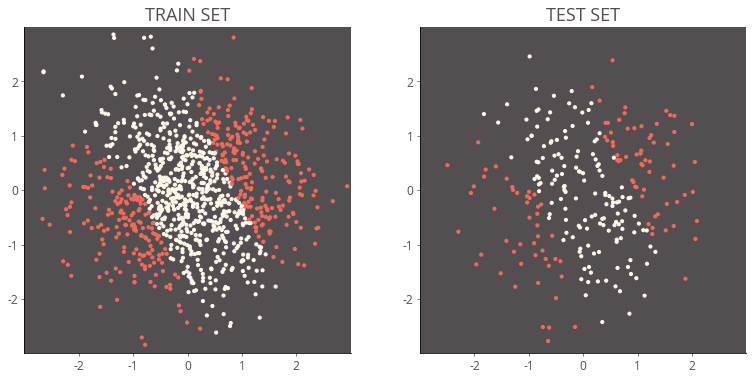

In [ ]:
# Create train and test sets

sc_data = torch.randn(1280, 2)
sc_priors_dict, sc_fc1_weight, sc_fc1_bias, sc_fc2_weight, sc_fc2_bias, sc_labels = generate_labels(sc_data)

print('fc1_weight = \n', sc_fc1_weight)
print('\nfc1_bias = \n', sc_fc1_bias)
print('\nfc2_weight = \n', sc_fc2_weight)
print('\nfc2_bias = \n', sc_fc2_bias)
# print('\n\n')

sc_train_data, sc_train_labels = sc_data[:1024], sc_labels[:1024]
sc_test_data, sc_test_labels = sc_data[1024:], sc_labels[1024:]
# print('Train Set : %4d samples - %s' % (len(sc_train_data), str(sc_train_data.shape)))
# print(' Test Set : %4d samples - %s' % (len(sc_test_data), str(sc_test_data.shape)))
# print('\n\n')

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
visualize_xor_data(ax[0], sc_train_data, sc_train_labels.int(), 'train set')
visualize_xor_data(ax[1], sc_test_data, sc_test_labels.int(), 'test set')

In [ ]:
# Creating Dataloaders

sc_train_dataset = TensorDataset(sc_train_data, sc_train_labels)
sc_test_dataset = TensorDataset(sc_test_data, sc_test_labels)

sc_train_loader = DataLoader(sc_train_dataset, batch_size=128, drop_last=True)
sc_test_loader = DataLoader(sc_test_dataset, batch_size=128, drop_last=True)

print('Train batches : %d' % len(sc_train_loader))
print(' Test batches : %d' % len(sc_test_loader))

Train batches : 8
 Test batches : 2


### **Models**

In [ ]:
class DNN(nn.Module):
    def __init__(self, in_size, hid_size, out_size):
        super().__init__()

        self._fc1 = nn.Linear(in_size, hid_size)
        self._fc2 = nn.Linear(hid_size, out_size)

    def forward(self, x):

        x = self._fc1(x)
        x = F.relu(x)
        x = self._fc2(x)
        x = F.sigmoid(x)

        return x

In [ ]:
class BNN(nn.Module):
    def __init__(self, model_dnn, in_size, hid_size, out_size):
        super().__init__()

        self.in_size = in_size
        self.hid_size = hid_size
        self.out_size = out_size
        self.model_dnn = model_dnn

    def model_bnn(self, x, y=None):
        _fc1w_prior = dist.Normal(loc=sc_priors_dict['w1_loc'].T,
                                  scale=sc_priors_dict['w1_scale'].T)
        _fc1b_prior = dist.Normal(loc=sc_priors_dict['b1_loc'].T,
                                  scale=sc_priors_dict['b1_scale'].T)
        
        _fc2w_prior = dist.Normal(loc=sc_priors_dict['w2_loc'].T,
                                  scale=sc_priors_dict['w2_scale'].T)
        _fc2b_prior = dist.Normal(loc=sc_priors_dict['b2_loc'].T,
                                  scale=sc_priors_dict['b2_scale'].T)
        
        priors_dict = {'_fc1.weight': _fc1w_prior,
                    '_fc1.bias': _fc1b_prior,
                    '_fc2.weight': _fc2w_prior,
                    '_fc2.bias': _fc2b_prior}
                    
        sampled_module = pyro.random_module('module', self.model_dnn, priors_dict)  
        sampled_model = sampled_module()
        probs = sampled_model(x)

        obs = pyro.sample('obs', dist.Bernoulli(probs), obs=y)

    def guide_bnn(self, x, y=None):
        _fc1w_loc = pyro.param('_fc1w_loc', torch.randn(self.hid_size, self.in_size))
        _fc1w_scale = torch.abs(pyro.param('_fc1w_scale', torch.randn(self.hid_size, self.in_size)))
        _fc1w_posterior = dist.Normal(loc=_fc1w_loc, scale=_fc1w_scale)

        _fc1b_loc = pyro.param('_fc1b_loc', torch.randn(self.hid_size))
        _fc1b_scale = torch.abs(pyro.param('_fc1b_scale', torch.randn(self.hid_size)))
        _fc1b_posterior = dist.Normal(loc=_fc1b_loc, scale=_fc1b_scale)

        _fc2w_loc = pyro.param('_fc2w_loc', torch.randn(self.out_size, self.hid_size))
        _fc2w_scale = torch.abs(pyro.param('_fc2w_scale', torch.randn(self.out_size, self.hid_size)))
        _fc2w_posterior = dist.Normal(loc=_fc2w_loc, scale=_fc2w_scale)
        
        _fc2b_loc = pyro.param('_fc2b_loc', torch.randn(self.out_size))
        _fc2b_scale = torch.abs(pyro.param('_fc2b_scale', torch.randn(self.out_size)))
        _fc2b_posterior = dist.Normal(loc=_fc2b_loc, scale=_fc2b_scale)
        
        posteriors_dict = {'_fc1.weight': _fc1w_posterior,
                    '_fc1.bias': _fc1b_posterior,
                    '_fc2.weight': _fc2w_posterior,
                    '_fc2.bias': _fc2b_posterior}
        
        sampled_module = pyro.random_module('module', self.model_dnn, posteriors_dict) 
        
        return sampled_module()

In [ ]:
# Define parameters and Initialize model

sc_model_dnn = DNN(2, 4, 1)

optimizer_dnn = torch.optim.Adam(sc_model_dnn.parameters(),
                                 lr=.001, weight_decay=.01) 
criterion_dnn = nn.BCELoss()

sc_model_bdnn = DNN(2, 4, 1)
sc_bnn_ = BNN(sc_model_bdnn, 2, 4, 1)

optimizer_bnn = pyro.optim.Adam({'lr': .01})
svi = SVI(sc_bnn_.model_bnn, sc_bnn_.guide_bnn, optimizer_bnn, loss=Trace_ELBO())

In [ ]:
# Training process

sc_train_data_dnn = {'train_loss': [], 'train_acc': []}
sc_train_data_bnn = {'train_loss': [], 'train_acc': []}

log_interval = 100
num_epochs = 1000

pyro.clear_param_store()
for epoch in range(num_epochs):

    train_loss_dnn, train_acc_dnn = train_dnn(sc_model_dnn, sc_train_loader, 
                                              criterion_dnn, optimizer_dnn, epoch)
    train_loss_bnn, train_acc_bnn = train_bnn(sc_train_loader, svi, epoch)
    
    sc_train_data_dnn['train_loss'].append(train_loss_dnn)
    sc_train_data_dnn['train_acc'].append(train_acc_dnn)

    sc_train_data_bnn['train_loss'].append(train_loss_bnn)
    sc_train_data_bnn['train_acc'].append(train_acc_bnn)

    if epoch == 0:        
        inter_params_store = {key: [] for key in pyro.get_param_store()}

    if (epoch+1) % log_interval == 0 or epoch == 0 or (epoch+1) == num_epochs:
        print('\nEPOCH {:>2d}'.format(epoch+1))
        print('   DNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_dnn,
                                                               train_acc_dnn))
        print('   BNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_bnn,
                                                               train_acc_bnn))
        
        inter_ps =  pyro.get_param_store()
        for key, param in inter_ps.items():
            inter_params_store[key].append(param.detach().clone())


EPOCH  1
   DNN loss:    0.6656371   |   acc: 0.6904297
   BNN loss:  962.1393354   |   acc: 0.6240234

EPOCH 100
   DNN loss:    0.4859885   |   acc: 0.8125000
   BNN loss:   47.0393791   |   acc: 0.9501953

EPOCH 200
   DNN loss:    0.3429234   |   acc: 0.8154297
   BNN loss:   42.4993065   |   acc: 0.9580078

EPOCH 300
   DNN loss:    0.2707509   |   acc: 0.9326172
   BNN loss:   41.2376100   |   acc: 0.9736328

EPOCH 400
   DNN loss:    0.2421887   |   acc: 0.9462891
   BNN loss:   43.1777967   |   acc: 0.9765625

EPOCH 500
   DNN loss:    0.2312548   |   acc: 0.9453125
   BNN loss:   43.4638817   |   acc: 0.9697266

EPOCH 600
   DNN loss:    0.2270301   |   acc: 0.9453125
   BNN loss:   42.7613549   |   acc: 0.9667969

EPOCH 700
   DNN loss:    0.2254526   |   acc: 0.9453125
   BNN loss:   40.2287773   |   acc: 0.9755859

EPOCH 800
   DNN loss:    0.2248721   |   acc: 0.9472656
   BNN loss:   40.3145736   |   acc: 0.9697266

EPOCH 900
   DNN loss:    0.2246370   |   acc: 0.947265

In [ ]:
ps =  pyro.get_param_store()
sc_params_store = dict()
for key, param in ps.items():
    sc_params_store[key] = param.detach().clone()

### **Performance**

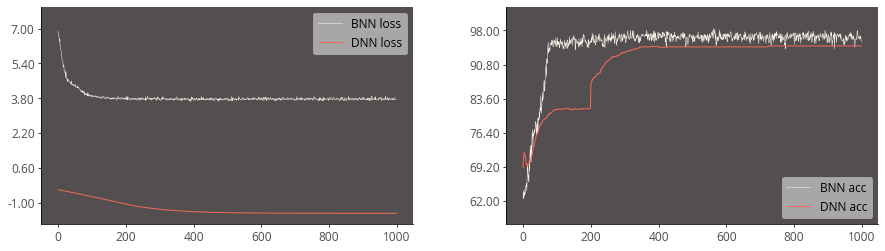

In [ ]:
# Display loss and accuracy

fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={'hspace': .5,
                                                          'wspace': .25})
  
train_loss_bnn = np.log(np.array(sc_train_data_bnn['train_loss']))
train_loss_dnn = np.log(np.array(sc_train_data_dnn['train_loss']))
plot_loss(ax[0], train_loss_bnn, train_loss_dnn)

train_acc_bnn = np.array(sc_train_data_bnn['train_acc'])*100
train_acc_dnn = np.array(sc_train_data_dnn['train_acc'])*100
plot_accuracies(ax[1], train_acc_bnn, train_acc_dnn)

In [ ]:
# Compute performance metrics

print('DEEP NEURAL NETWORK')
print('-' * 64)
sc_metrics_dnn = compute_performance_dnn(sc_model_dnn, sc_test_loader)

print('\n\nBAYESIAN NEURAL NETWORK')
print('-' * 64)
sc_metrics_bnn = compute_performance_bnn(sc_bnn_.guide_bnn, sc_test_loader)

DEEP NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       110
           1       0.92      0.99      0.95       146

    accuracy                           0.95       256
   macro avg       0.95      0.94      0.94       256
weighted avg       0.95      0.95      0.94       256



BAYESIAN NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       110
           1       0.97      0.99      0.98       146

    accuracy                           0.98       256
   macro avg       0.98      0.97      0.98       256
weighted avg       0.98      0.98      0.98       256



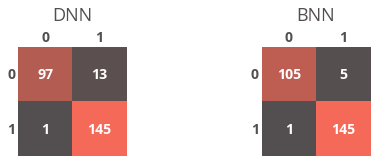

In [ ]:
# Display confusion matrix

fig, ax = plt.subplots(1, 2, figsize=(8, 2))

plot_confusion_matrix(ax[0], sc_metrics_dnn['conf_matrix'], 'dnn')
plot_confusion_matrix(ax[1], sc_metrics_bnn['conf_matrix'], 'bnn')

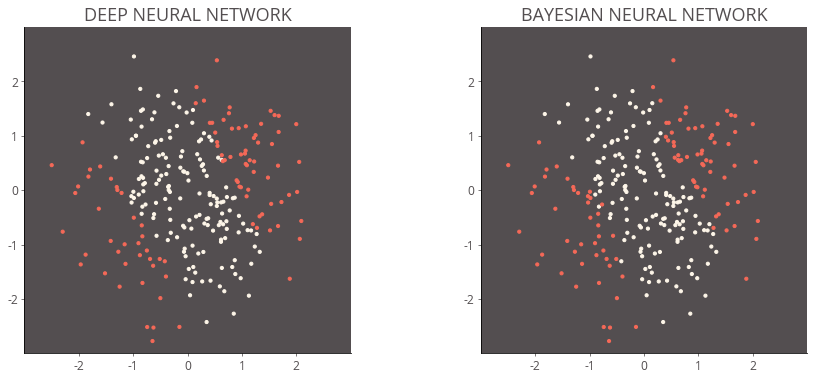

In [ ]:
# Display predictions for test data

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

visualize_xor_data(ax[0], sc_metrics_dnn['test_data'], sc_metrics_dnn['pred_labels'], 
                   'deep neural network')
visualize_xor_data(ax[1], sc_metrics_bnn['test_data'], sc_metrics_bnn['pred_labels'], 
                   'bayesian neural network')

## **Posterior distributions Analysis**

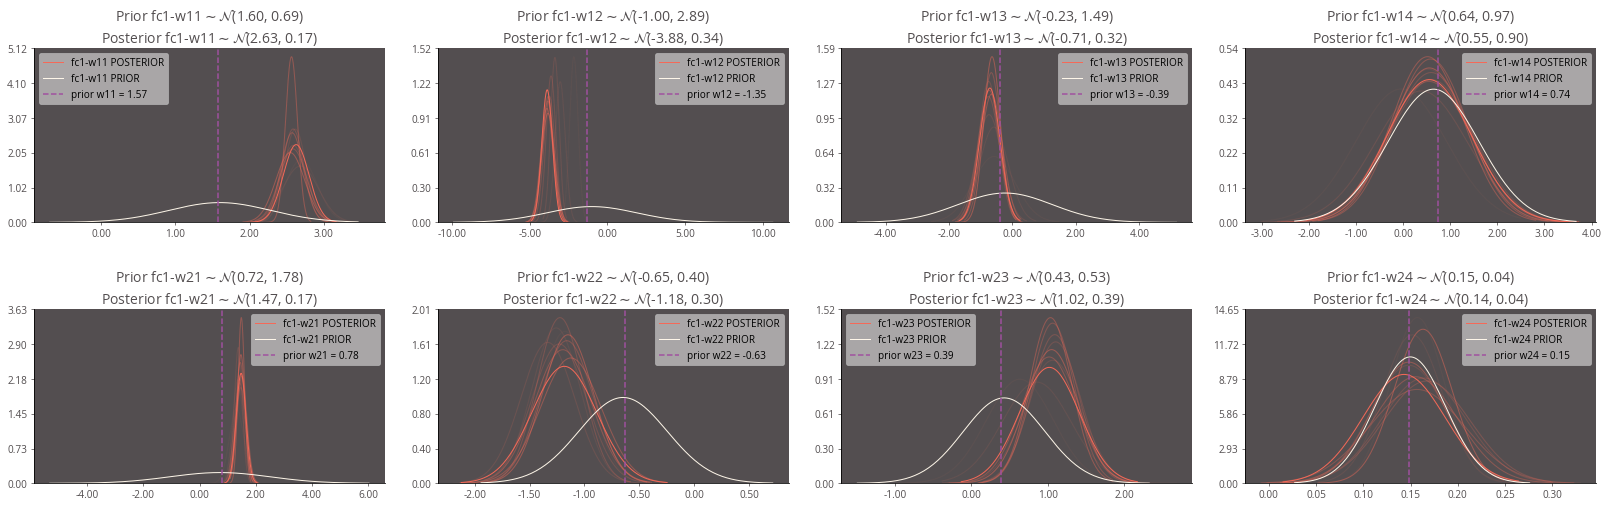

In [ ]:
# FC1 weight

fig, ax = plt.subplots(2, 4, figsize=(28, 8), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        
        prior_name = 'w{:s}'.format(layer[-1])
        loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col, row]
        scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col, row]
        prior_value = sc_fc1_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row, col], param_name, 
                              loc_post, scale_post, 
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

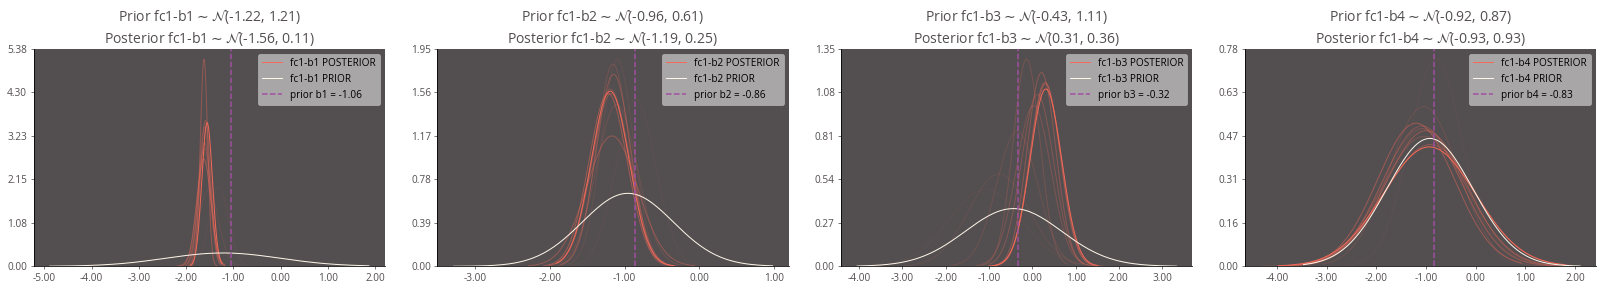

In [ ]:
# FC1 bias

fig, ax = plt.subplots(1, 4, figsize=(28, 4), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
        
    prior_name = 'b{:s}'.format(layer[-1])
    loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col]
    scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col]
    prior_value = sc_fc1_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax[col], param_name, 
                          loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

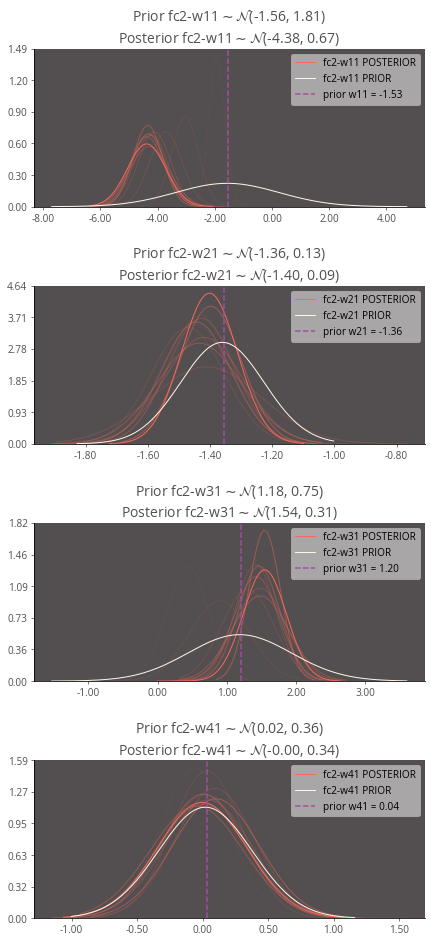

In [ ]:
# FC2 weight

fig, ax = plt.subplots(4, 1, figsize=(7, 16), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        
        prior_name = 'w{:s}'.format(layer[-1])
        loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col, row]
        scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col, row]
        prior_value = sc_fc2_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row], param_name, 
                              loc_post, scale_post,
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

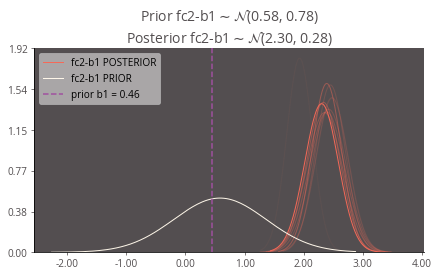

In [ ]:
# FC2 bias

fig, ax = plt.subplots(1, 1, figsize=(7, 3.75), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
        
    prior_name = 'b{:s}'.format(layer[-1])
    loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col]
    scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col]
    prior_value = sc_fc2_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax, param_name, 
                          loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

# **Sanity Check 4**


Data labeled using random initialization for the weights and biases distributions parameters
> $\mu_{_{SC}} \sim \mathcal{N}(0, 1)$  
> $\sigma_{_{SC}} \sim \mathcal{N}(0, 1) $   
> $w, b \sim \mathcal{N}(\mu_{_{SC}}, \sigma_{_{SC}})$



In [ ]:
# Generate sanity-check data

def generate_labels(data):
    w1_loc = torch.randn(4, 2).float().T
    w1_scale = torch.abs(torch.randn(4, 2).float().T)
    w1_dist = torch.distributions.Normal(loc=w1_loc, scale=w1_scale)
    fc1_weight = []
    for _ in range(1):
        fc1_weight.append(w1_dist.sample())
    fc1_weight = torch.stack(fc1_weight)
    fc1_weight = fc1_weight.mean(dim=0)

    b1_loc = torch.randn(4).float()
    b1_scale = torch.abs(torch.randn(4).float())
    b1_dist = torch.distributions.Normal(loc=b1_loc, scale=b1_scale)
    fc1_bias = []
    for _ in range(1):
        fc1_bias.append(b1_dist.sample())
    fc1_bias = torch.stack(fc1_bias)
    fc1_bias = fc1_bias.mean(dim=0)
    
    w2_loc = torch.randn(1, 4).float().T
    w2_scale = torch.abs(torch.randn(1, 4).float().T)
    w2_dist = torch.distributions.Normal(loc=w2_loc, scale=w2_scale)
    fc2_weight = []
    for _ in range(1):
        fc2_weight.append(w2_dist.sample())
    fc2_weight = torch.stack(fc2_weight)
    fc2_weight = fc2_weight.mean(dim=0)

    b2_loc = torch.randn(1).float()
    b2_scale = torch.abs(torch.randn(1).float())
    b2_dist = torch.distributions.Normal(loc=b2_loc, scale=b2_scale)
    fc2_bias = []
    for _ in range(1):
        fc2_bias.append(b2_dist.sample())
    fc2_bias = torch.stack(fc2_bias)
    fc2_bias = fc2_bias.mean(dim=0)

    labels = torch.matmul(data, fc1_weight) + fc1_bias
    labels = F.relu(labels)
    labels = torch.matmul(labels, fc2_weight) + fc2_bias
    labels = F.sigmoid(labels).squeeze()
    labels = (labels > .5).float()

    priors_dict = {'w1_loc': w1_loc, 'w1_scale': w1_scale,
                   'b1_loc': b1_loc, 'b1_scale': b1_scale,
                   'w2_loc': w2_loc, 'w2_scale': w2_scale,
                   'b2_loc': b2_loc, 'b2_scale': b2_scale}

    return priors_dict, fc1_weight, fc1_bias, fc2_weight, fc2_bias, labels

fc1_weight = 
 tensor([[-0.1578, -1.1404, -0.1917, -1.2438],
        [ 0.2296,  0.1715,  1.4862, -1.2352]])

fc1_bias = 
 tensor([ 0.3300,  1.0287,  0.8502, -0.0930])

fc2_weight = 
 tensor([[0.4089],
        [0.0669],
        [0.7815],
        [1.2047]])

fc2_bias = 
 tensor([-1.3181])


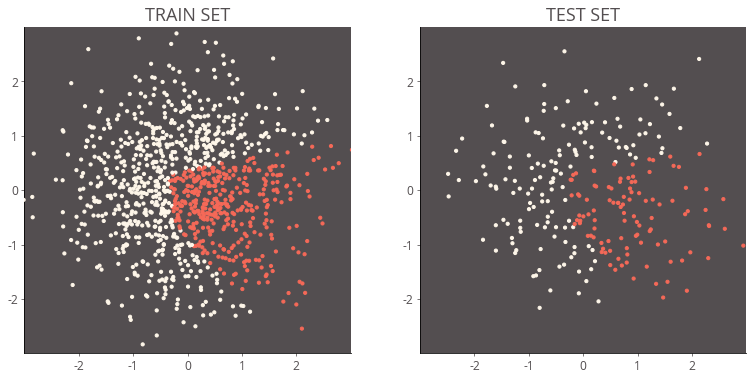

In [ ]:
# Create train and test sets

sc_data = torch.randn(1280, 2)
sc_priors_dict, sc_fc1_weight, sc_fc1_bias, sc_fc2_weight, sc_fc2_bias, sc_labels = generate_labels(sc_data)

print('fc1_weight = \n', sc_fc1_weight)
print('\nfc1_bias = \n', sc_fc1_bias)
print('\nfc2_weight = \n', sc_fc2_weight)
print('\nfc2_bias = \n', sc_fc2_bias)
# print('\n\n')

sc_train_data, sc_train_labels = sc_data[:1024], sc_labels[:1024]
sc_test_data, sc_test_labels = sc_data[1024:], sc_labels[1024:]
# print('Train Set : %4d samples - %s' % (len(sc_train_data), str(sc_train_data.shape)))
# print(' Test Set : %4d samples - %s' % (len(sc_test_data), str(sc_test_data.shape)))
# print('\n\n')

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
visualize_xor_data(ax[0], sc_train_data, sc_train_labels.int(), 'train set')
visualize_xor_data(ax[1], sc_test_data, sc_test_labels.int(), 'test set')

In [ ]:
# Creating Dataloaders

sc_train_dataset = TensorDataset(sc_train_data, sc_train_labels)
sc_test_dataset = TensorDataset(sc_test_data, sc_test_labels)

sc_train_loader = DataLoader(sc_train_dataset, batch_size=128, drop_last=True)
sc_test_loader = DataLoader(sc_test_dataset, batch_size=128, drop_last=True)

print('Train batches : %d' % len(sc_train_loader))
print(' Test batches : %d' % len(sc_test_loader))

Train batches : 8
 Test batches : 2


### **Models**

In [ ]:
class DNN(nn.Module):
    def __init__(self, in_size, hid_size, out_size):
        super().__init__()

        self._fc1 = nn.Linear(in_size, hid_size)
        self._fc2 = nn.Linear(hid_size, out_size)

    def forward(self, x):

        x = self._fc1(x)
        x = F.relu(x)
        x = self._fc2(x)
        x = F.sigmoid(x)

        return x

In [ ]:
class BNN(nn.Module):
    def __init__(self, model_dnn, in_size, hid_size, out_size):
        super().__init__()

        self.in_size = in_size
        self.hid_size = hid_size
        self.out_size = out_size
        self.model_dnn = model_dnn

    def model_bnn(self, x, y=None):
        _fc1w_prior = dist.Normal(loc=sc_priors_dict['w1_loc'].T,
                                  scale=sc_priors_dict['w1_scale'].T)
        _fc1b_prior = dist.Normal(loc=sc_priors_dict['b1_loc'].T,
                                  scale=sc_priors_dict['b1_scale'].T)
        
        _fc2w_prior = dist.Normal(loc=sc_priors_dict['w2_loc'].T,
                                  scale=sc_priors_dict['w2_scale'].T)
        _fc2b_prior = dist.Normal(loc=sc_priors_dict['b2_loc'].T,
                                  scale=sc_priors_dict['b2_scale'].T)
        
        priors_dict = {'_fc1.weight': _fc1w_prior,
                    '_fc1.bias': _fc1b_prior,
                    '_fc2.weight': _fc2w_prior,
                    '_fc2.bias': _fc2b_prior}
                    
        sampled_module = pyro.random_module('module', self.model_dnn, priors_dict)  
        sampled_model = sampled_module()
        probs = sampled_model(x)

        obs = pyro.sample('obs', dist.Bernoulli(probs), obs=y)

    def guide_bnn(self, x, y=None):
        _fc1w_loc = pyro.param('_fc1w_loc', torch.randn(self.hid_size, self.in_size))
        _fc1w_scale = torch.abs(pyro.param('_fc1w_scale', torch.randn(self.hid_size, self.in_size)))
        _fc1w_posterior = dist.Normal(loc=_fc1w_loc, scale=_fc1w_scale)

        _fc1b_loc = pyro.param('_fc1b_loc', torch.randn(self.hid_size))
        _fc1b_scale = torch.abs(pyro.param('_fc1b_scale', torch.randn(self.hid_size)))
        _fc1b_posterior = dist.Normal(loc=_fc1b_loc, scale=_fc1b_scale)

        _fc2w_loc = pyro.param('_fc2w_loc', torch.randn(self.out_size, self.hid_size))
        _fc2w_scale = torch.abs(pyro.param('_fc2w_scale', torch.randn(self.out_size, self.hid_size)))
        _fc2w_posterior = dist.Normal(loc=_fc2w_loc, scale=_fc2w_scale)
        
        _fc2b_loc = pyro.param('_fc2b_loc', torch.randn(self.out_size))
        _fc2b_scale = torch.abs(pyro.param('_fc2b_scale', torch.randn(self.out_size)))
        _fc2b_posterior = dist.Normal(loc=_fc2b_loc, scale=_fc2b_scale)
        
        posteriors_dict = {'_fc1.weight': _fc1w_posterior,
                    '_fc1.bias': _fc1b_posterior,
                    '_fc2.weight': _fc2w_posterior,
                    '_fc2.bias': _fc2b_posterior}
        
        sampled_module = pyro.random_module('module', self.model_dnn, posteriors_dict) 
        
        return sampled_module()

In [ ]:
# Define parameters and Initialize model

sc_model_dnn = DNN(2, 4, 1)

optimizer_dnn = torch.optim.Adam(sc_model_dnn.parameters(),
                                 lr=.001, weight_decay=.01) 
criterion_dnn = nn.BCELoss()

sc_model_bdnn = DNN(2, 4, 1)
sc_bnn_ = BNN(sc_model_bdnn, 2, 4, 1)

optimizer_bnn = pyro.optim.Adam({'lr': .025})
svi = SVI(sc_bnn_.model_bnn, sc_bnn_.guide_bnn, optimizer_bnn, loss=Trace_ELBO())

In [ ]:
# Training process

sc_train_data_dnn = {'train_loss': [], 'train_acc': []}
sc_train_data_bnn = {'train_loss': [], 'train_acc': []}

log_interval = 100
num_epochs = 1000

pyro.clear_param_store()
for epoch in range(num_epochs):

    train_loss_dnn, train_acc_dnn = train_dnn(sc_model_dnn, sc_train_loader, 
                                              criterion_dnn, optimizer_dnn, epoch)
    train_loss_bnn, train_acc_bnn = train_bnn(sc_train_loader, svi, epoch)
    
    sc_train_data_dnn['train_loss'].append(train_loss_dnn)
    sc_train_data_dnn['train_acc'].append(train_acc_dnn)

    sc_train_data_bnn['train_loss'].append(train_loss_bnn)
    sc_train_data_bnn['train_acc'].append(train_acc_bnn)

    if epoch == 0:        
        inter_params_store = {key: [] for key in pyro.get_param_store()}

    if (epoch+1) % log_interval == 0 or epoch == 0 or (epoch+1) == num_epochs:
        print('\nEPOCH {:>2d}'.format(epoch+1))
        print('   DNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_dnn,
                                                               train_acc_dnn))
        print('   BNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_bnn,
                                                               train_acc_bnn))
        
        inter_ps =  pyro.get_param_store()
        for key, param in inter_ps.items():
            inter_params_store[key].append(param.detach().clone())


EPOCH  1
   DNN loss:    0.6043134   |   acc: 0.8017578
   BNN loss:  557.2723309   |   acc: 0.5937500

EPOCH 100
   DNN loss:    0.3846760   |   acc: 0.8232422
   BNN loss:   52.9216083   |   acc: 0.9404297

EPOCH 200
   DNN loss:    0.2463886   |   acc: 0.9208984
   BNN loss:   47.2973640   |   acc: 0.9550781

EPOCH 300
   DNN loss:    0.1821748   |   acc: 0.9472656
   BNN loss:   47.6926098   |   acc: 0.9414062

EPOCH 400
   DNN loss:    0.1601682   |   acc: 0.9570312
   BNN loss:   47.3867817   |   acc: 0.9443359

EPOCH 500
   DNN loss:    0.1527196   |   acc: 0.9609375
   BNN loss:   47.4923707   |   acc: 0.9492188

EPOCH 600
   DNN loss:    0.1501897   |   acc: 0.9628906
   BNN loss:   45.9653339   |   acc: 0.9658203

EPOCH 700
   DNN loss:    0.1493440   |   acc: 0.9628906
   BNN loss:   48.5558079   |   acc: 0.9462891

EPOCH 800
   DNN loss:    0.1490782   |   acc: 0.9638672
   BNN loss:   49.3803691   |   acc: 0.9482422

EPOCH 900
   DNN loss:    0.1489806   |   acc: 0.963867

In [ ]:
ps =  pyro.get_param_store()
sc_params_store = dict()
for key, param in ps.items():
    sc_params_store[key] = param.detach().clone()

### **Performance**

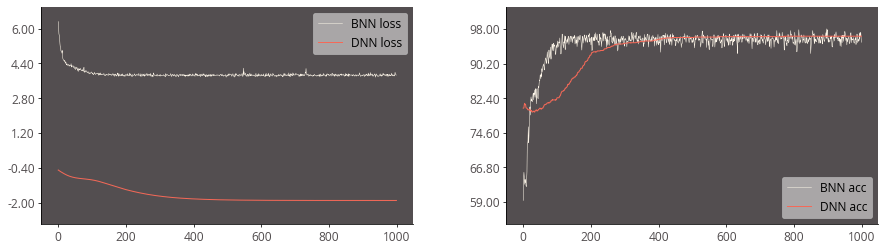

In [ ]:
# Display loss and accuracy

fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={'hspace': .5,
                                                          'wspace': .25})
  
train_loss_bnn = np.log(np.array(sc_train_data_bnn['train_loss']))
train_loss_dnn = np.log(np.array(sc_train_data_dnn['train_loss']))
plot_loss(ax[0], train_loss_bnn, train_loss_dnn)

train_acc_bnn = np.array(sc_train_data_bnn['train_acc'])*100
train_acc_dnn = np.array(sc_train_data_dnn['train_acc'])*100
plot_accuracies(ax[1], train_acc_bnn, train_acc_dnn)

In [ ]:
# Compute performance metrics

print('DEEP NEURAL NETWORK')
print('-' * 64)
sc_metrics_dnn = compute_performance_dnn(sc_model_dnn, sc_test_loader)

print('\n\nBAYESIAN NEURAL NETWORK')
print('-' * 64)
sc_metrics_bnn = compute_performance_bnn(sc_bnn_.guide_bnn, sc_test_loader)

DEEP NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       104
           1       0.97      0.98      0.97       152

    accuracy                           0.97       256
   macro avg       0.97      0.97      0.97       256
weighted avg       0.97      0.97      0.97       256



BAYESIAN NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       104
           1       0.99      0.96      0.97       152

    accuracy                           0.97       256
   macro avg       0.97      0.97      0.97       256
weighted avg       0.97      0.97      0.97       256



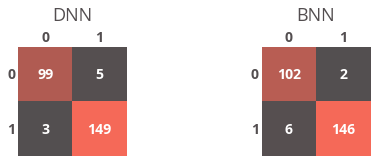

In [ ]:
# Display confusion matrix

fig, ax = plt.subplots(1, 2, figsize=(8, 2))

plot_confusion_matrix(ax[0], sc_metrics_dnn['conf_matrix'], 'dnn')
plot_confusion_matrix(ax[1], sc_metrics_bnn['conf_matrix'], 'bnn')

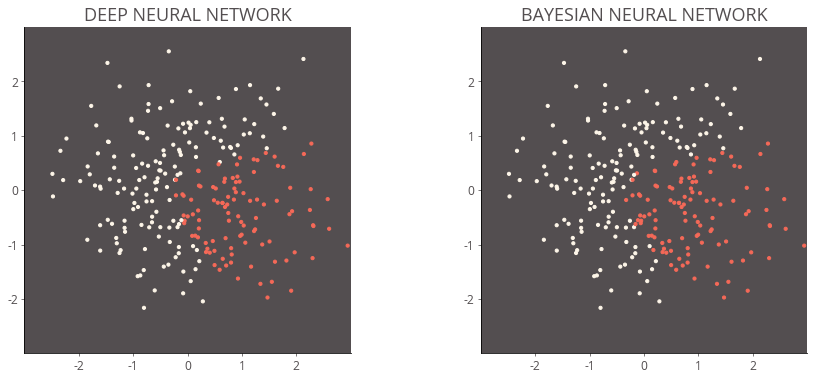

In [ ]:
# Display predictions for test data

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

visualize_xor_data(ax[0], sc_metrics_dnn['test_data'], sc_metrics_dnn['pred_labels'], 
                   'deep neural network')
visualize_xor_data(ax[1], sc_metrics_bnn['test_data'], sc_metrics_bnn['pred_labels'], 
                   'bayesian neural network')

## **Posterior distributions Analysis**

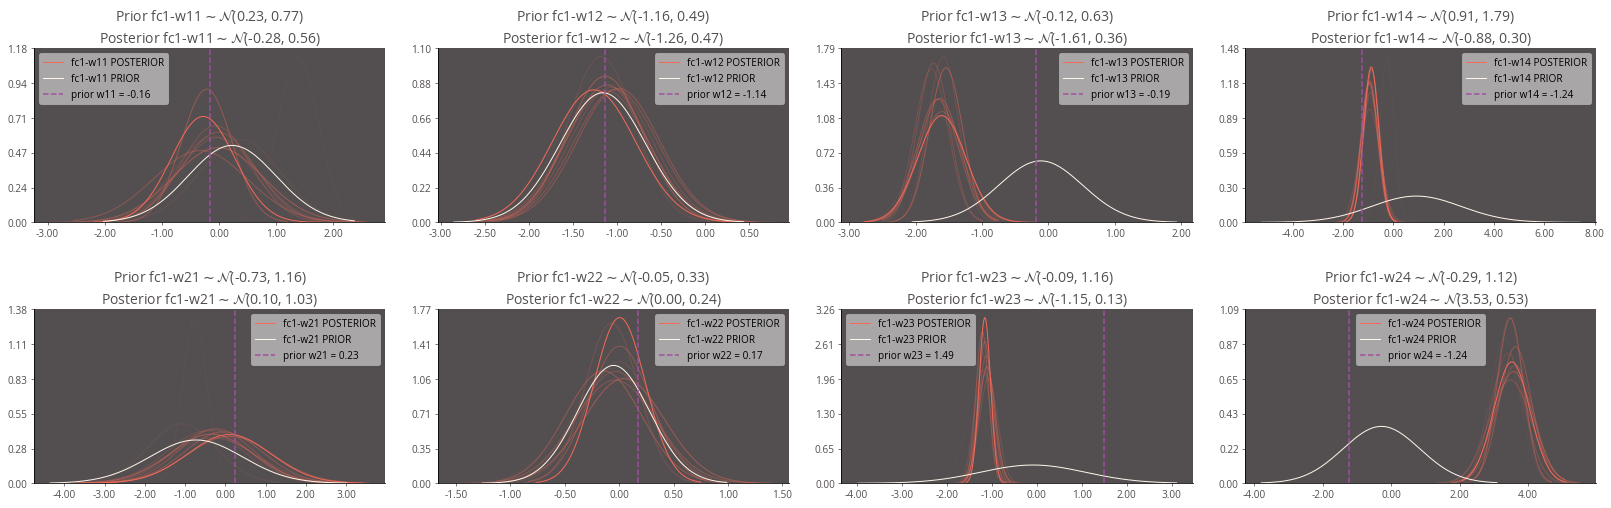

In [ ]:
# FC1 weight

fig, ax = plt.subplots(2, 4, figsize=(28, 8), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        
        prior_name = 'w{:s}'.format(layer[-1])
        loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col, row]
        scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col, row]
        prior_value = sc_fc1_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row, col], param_name, 
                              loc_post, scale_post, 
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

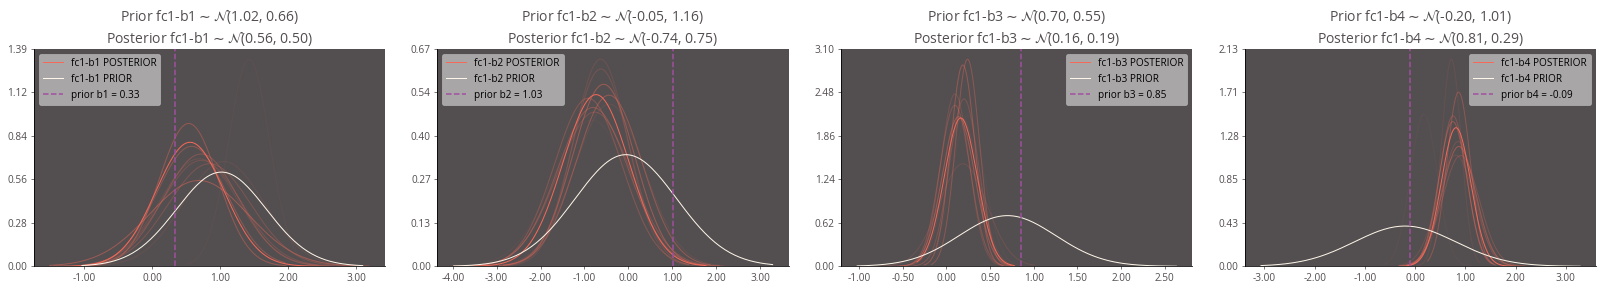

In [ ]:
# FC1 bias

fig, ax = plt.subplots(1, 4, figsize=(28, 4), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
        
    prior_name = 'b{:s}'.format(layer[-1])
    loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col]
    scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col]
    prior_value = sc_fc1_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax[col], param_name, 
                          loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

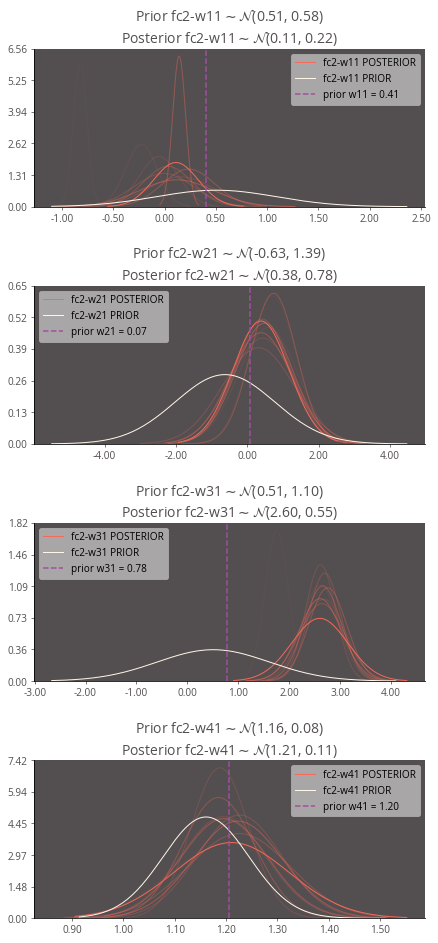

In [ ]:
# FC2 weight

fig, ax = plt.subplots(4, 1, figsize=(7, 16), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        
        prior_name = 'w{:s}'.format(layer[-1])
        loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col, row]
        scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col, row]
        prior_value = sc_fc2_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row], param_name, 
                              loc_post, scale_post,
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

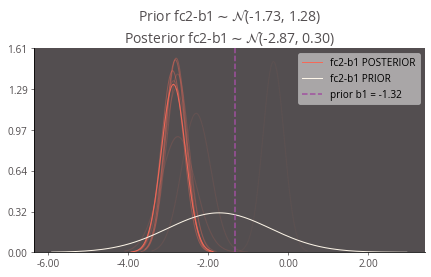

In [ ]:
# FC2 bias

fig, ax = plt.subplots(1, 1, figsize=(7, 3.75), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
        
    prior_name = 'b{:s}'.format(layer[-1])
    loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col]
    scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col]
    prior_value = sc_fc2_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax, param_name, 
                          loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

# **Sanity Check 5**


Data labeled using random initialization for the weights and biases distributions parameters
> $\mu_{_{SC}} \sim \mathcal{N}(0, 1) \times c$  
> $\sigma_{_{SC}} \sim \mathcal{N}(0, 1) \times c$ ,  where $c \sim \mathcal{U}(0, 1)$  
> $w, b \sim \mathcal{N}(\mu_{_{SC}}, \sigma_{_{SC}})$



In [ ]:
# Generate sanity-check data

def generate_labels(data):
    c = torch.rand(1)
    w1_loc = torch.randn(4, 2).float().T * c
    w1_scale = torch.abs(torch.randn(4, 2).float().T * c)
    w1_dist = torch.distributions.Normal(loc=w1_loc, scale=w1_scale)
    fc1_weight = []
    for _ in range(1):
        fc1_weight.append(w1_dist.sample())
    fc1_weight = torch.stack(fc1_weight)
    fc1_weight = fc1_weight.mean(dim=0)

    b1_loc = torch.randn(4).float() * c
    b1_scale = torch.abs(torch.randn(4).float() * c)
    b1_dist = torch.distributions.Normal(loc=b1_loc, scale=b1_scale)
    fc1_bias = []
    for _ in range(1):
        fc1_bias.append(b1_dist.sample())
    fc1_bias = torch.stack(fc1_bias)
    fc1_bias = fc1_bias.mean(dim=0)
    
    w2_loc = torch.randn(1, 4).float().T * c
    w2_scale = torch.abs(torch.randn(1, 4).float().T * c)
    w2_dist = torch.distributions.Normal(loc=w2_loc, scale=w2_scale)
    fc2_weight = []
    for _ in range(1):
        fc2_weight.append(w2_dist.sample())
    fc2_weight = torch.stack(fc2_weight)
    fc2_weight = fc2_weight.mean(dim=0)

    b2_loc = torch.randn(1).float() * c
    b2_scale = torch.abs(torch.randn(1).float() * c)
    b2_dist = torch.distributions.Normal(loc=b2_loc, scale=b2_scale)
    fc2_bias = []
    for _ in range(1):
        fc2_bias.append(b2_dist.sample())
    fc2_bias = torch.stack(fc2_bias)
    fc2_bias = fc2_bias.mean(dim=0)

    labels = torch.matmul(data, fc1_weight) + fc1_bias
    labels = F.relu(labels)
    labels = torch.matmul(labels, fc2_weight) + fc2_bias
    labels = F.sigmoid(labels).squeeze()
    labels = (labels > .5).float()

    priors_dict = {'w1_loc': w1_loc, 'w1_scale': w1_scale,
                   'b1_loc': b1_loc, 'b1_scale': b1_scale,
                   'w2_loc': w2_loc, 'w2_scale': w2_scale,
                   'b2_loc': b2_loc, 'b2_scale': b2_scale}

    return priors_dict, fc1_weight, fc1_bias, fc2_weight, fc2_bias, labels

fc1_weight = 
 tensor([[-0.3293,  0.0174, -1.7533, -2.6119],
        [ 1.9058,  0.7073, -0.2925,  0.1964]])

fc1_bias = 
 tensor([ 0.9089, -1.3898,  1.4598, -0.6300])

fc2_weight = 
 tensor([[ 1.3848],
        [ 1.1878],
        [-1.3195],
        [ 0.4231]])

fc2_bias = 
 tensor([1.6526])


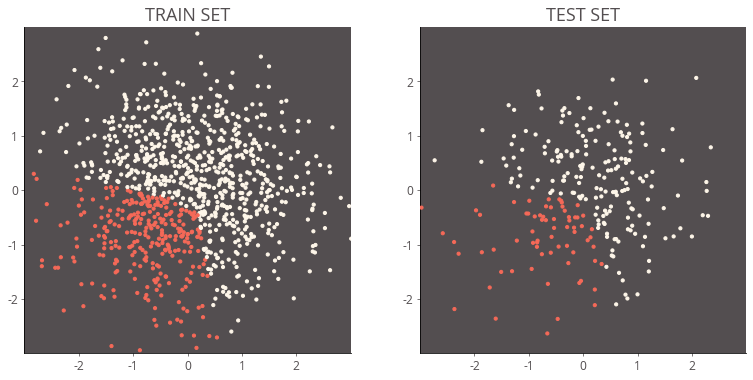

In [ ]:
# Create train and test sets

sc_data = torch.randn(1280, 2)
sc_priors_dict, sc_fc1_weight, sc_fc1_bias, sc_fc2_weight, sc_fc2_bias, sc_labels = generate_labels(sc_data)

print('fc1_weight = \n', sc_fc1_weight)
print('\nfc1_bias = \n', sc_fc1_bias)
print('\nfc2_weight = \n', sc_fc2_weight)
print('\nfc2_bias = \n', sc_fc2_bias)
# print('\n\n')

sc_train_data, sc_train_labels = sc_data[:1024], sc_labels[:1024]
sc_test_data, sc_test_labels = sc_data[1024:], sc_labels[1024:]
# print('Train Set : %4d samples - %s' % (len(sc_train_data), str(sc_train_data.shape)))
# print(' Test Set : %4d samples - %s' % (len(sc_test_data), str(sc_test_data.shape)))
# print('\n\n')

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
visualize_xor_data(ax[0], sc_train_data, sc_train_labels.int(), 'train set')
visualize_xor_data(ax[1], sc_test_data, sc_test_labels.int(), 'test set')

In [ ]:
# Creating Dataloaders

sc_train_dataset = TensorDataset(sc_train_data, sc_train_labels)
sc_test_dataset = TensorDataset(sc_test_data, sc_test_labels)

sc_train_loader = DataLoader(sc_train_dataset, batch_size=128, drop_last=True)
sc_test_loader = DataLoader(sc_test_dataset, batch_size=128, drop_last=True)

print('Train batches : %d' % len(sc_train_loader))
print(' Test batches : %d' % len(sc_test_loader))

Train batches : 8
 Test batches : 2


### **Models**

In [ ]:
class DNN(nn.Module):
    def __init__(self, in_size, hid_size, out_size):
        super().__init__()

        self._fc1 = nn.Linear(in_size, hid_size)
        self._fc2 = nn.Linear(hid_size, out_size)

    def forward(self, x):

        x = self._fc1(x)
        x = F.relu(x)
        x = self._fc2(x)
        x = F.sigmoid(x)

        return x

In [ ]:
class BNN(nn.Module):
    def __init__(self, model_dnn, in_size, hid_size, out_size):
        super().__init__()

        self.in_size = in_size
        self.hid_size = hid_size
        self.out_size = out_size
        self.model_dnn = model_dnn

    def model_bnn(self, x, y=None):
        _fc1w_prior = dist.Normal(loc=sc_priors_dict['w1_loc'].T,
                                  scale=sc_priors_dict['w1_scale'].T)
        _fc1b_prior = dist.Normal(loc=sc_priors_dict['b1_loc'].T,
                                  scale=sc_priors_dict['b1_scale'].T)
        
        _fc2w_prior = dist.Normal(loc=sc_priors_dict['w2_loc'].T,
                                  scale=sc_priors_dict['w2_scale'].T)
        _fc2b_prior = dist.Normal(loc=sc_priors_dict['b2_loc'].T,
                                  scale=sc_priors_dict['b2_scale'].T)
        
        priors_dict = {'_fc1.weight': _fc1w_prior,
                    '_fc1.bias': _fc1b_prior,
                    '_fc2.weight': _fc2w_prior,
                    '_fc2.bias': _fc2b_prior}
                    
        sampled_module = pyro.random_module('module', self.model_dnn, priors_dict)  
        sampled_model = sampled_module()
        probs = sampled_model(x)

        obs = pyro.sample('obs', dist.Bernoulli(probs), obs=y)

    def guide_bnn(self, x, y=None):
        _fc1w_loc = pyro.param('_fc1w_loc', torch.randn(self.hid_size, self.in_size))
        _fc1w_scale = torch.abs(pyro.param('_fc1w_scale', torch.randn(self.hid_size, self.in_size)))
        _fc1w_posterior = dist.Normal(loc=_fc1w_loc, scale=_fc1w_scale)

        _fc1b_loc = pyro.param('_fc1b_loc', torch.randn(self.hid_size))
        _fc1b_scale = torch.abs(pyro.param('_fc1b_scale', torch.randn(self.hid_size)))
        _fc1b_posterior = dist.Normal(loc=_fc1b_loc, scale=_fc1b_scale)

        _fc2w_loc = pyro.param('_fc2w_loc', torch.randn(self.out_size, self.hid_size))
        _fc2w_scale = torch.abs(pyro.param('_fc2w_scale', torch.randn(self.out_size, self.hid_size)))
        _fc2w_posterior = dist.Normal(loc=_fc2w_loc, scale=_fc2w_scale)
        
        _fc2b_loc = pyro.param('_fc2b_loc', torch.randn(self.out_size))
        _fc2b_scale = torch.abs(pyro.param('_fc2b_scale', torch.randn(self.out_size)))
        _fc2b_posterior = dist.Normal(loc=_fc2b_loc, scale=_fc2b_scale)
        
        posteriors_dict = {'_fc1.weight': _fc1w_posterior,
                    '_fc1.bias': _fc1b_posterior,
                    '_fc2.weight': _fc2w_posterior,
                    '_fc2.bias': _fc2b_posterior}
        
        sampled_module = pyro.random_module('module', self.model_dnn, posteriors_dict) 
        
        return sampled_module()

In [ ]:
# Define parameters and Initialize model

sc_model_dnn = DNN(2, 4, 1)

optimizer_dnn = torch.optim.Adam(sc_model_dnn.parameters(),
                                 lr=.001, weight_decay=.01) 
criterion_dnn = nn.BCELoss()

sc_model_bdnn = DNN(2, 4, 1)
sc_bnn_ = BNN(sc_model_bdnn, 2, 4, 1)

optimizer_bnn = pyro.optim.Adam({'lr': .01})
svi = SVI(sc_bnn_.model_bnn, sc_bnn_.guide_bnn, optimizer_bnn, loss=Trace_ELBO())

In [ ]:
# Training process

sc_train_data_dnn = {'train_loss': [], 'train_acc': []}
sc_train_data_bnn = {'train_loss': [], 'train_acc': []}

log_interval = 100
num_epochs = 1000

pyro.clear_param_store()
for epoch in range(num_epochs):

    train_loss_dnn, train_acc_dnn = train_dnn(sc_model_dnn, sc_train_loader, 
                                              criterion_dnn, optimizer_dnn, epoch)
    train_loss_bnn, train_acc_bnn = train_bnn(sc_train_loader, svi, epoch)
    
    sc_train_data_dnn['train_loss'].append(train_loss_dnn)
    sc_train_data_dnn['train_acc'].append(train_acc_dnn)

    sc_train_data_bnn['train_loss'].append(train_loss_bnn)
    sc_train_data_bnn['train_acc'].append(train_acc_bnn)

    if epoch == 0:        
        inter_params_store = {key: [] for key in pyro.get_param_store()}

    if (epoch+1) % log_interval == 0 or epoch == 0 or (epoch+1) == num_epochs:
        print('\nEPOCH {:>2d}'.format(epoch+1))
        print('   DNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_dnn,
                                                               train_acc_dnn))
        print('   BNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_bnn,
                                                               train_acc_bnn))
        
        inter_ps =  pyro.get_param_store()
        for key, param in inter_ps.items():
            inter_params_store[key].append(param.detach().clone())


EPOCH  1
   DNN loss:    0.7582901   |   acc: 0.2841797
   BNN loss:  328.1319794   |   acc: 0.6064453

EPOCH 100
   DNN loss:    0.3222796   |   acc: 0.9355469
   BNN loss:   34.9723213   |   acc: 0.9550781

EPOCH 200
   DNN loss:    0.1483199   |   acc: 0.9638672
   BNN loss:   32.9596890   |   acc: 0.9707031

EPOCH 300
   DNN loss:    0.1223332   |   acc: 0.9716797
   BNN loss:   28.5254080   |   acc: 0.9707031

EPOCH 400
   DNN loss:    0.1141555   |   acc: 0.9736328
   BNN loss:   26.9847917   |   acc: 0.9833984

EPOCH 500
   DNN loss:    0.1110875   |   acc: 0.9785156
   BNN loss:   28.4300074   |   acc: 0.9824219

EPOCH 600
   DNN loss:    0.1098873   |   acc: 0.9785156
   BNN loss:   29.1852035   |   acc: 0.9765625

EPOCH 700
   DNN loss:    0.1093615   |   acc: 0.9794922
   BNN loss:   28.9685171   |   acc: 0.9785156

EPOCH 800
   DNN loss:    0.1090938   |   acc: 0.9794922
   BNN loss:   26.7553865   |   acc: 0.9716797

EPOCH 900
   DNN loss:    0.1089832   |   acc: 0.979492

In [ ]:
ps =  pyro.get_param_store()
sc_params_store = dict()
for key, param in ps.items():
    sc_params_store[key] = param.detach().clone()

### **Performance**

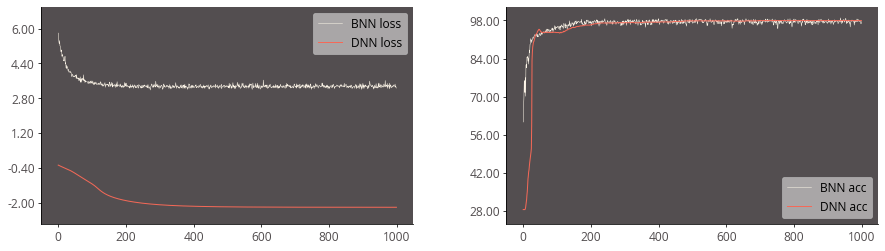

In [ ]:
# Display loss and accuracy

fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={'hspace': .5,
                                                          'wspace': .25})
  
train_loss_bnn = np.log(np.array(sc_train_data_bnn['train_loss']))
train_loss_dnn = np.log(np.array(sc_train_data_dnn['train_loss']))
plot_loss(ax[0], train_loss_bnn, train_loss_dnn)

train_acc_bnn = np.array(sc_train_data_bnn['train_acc'])*100
train_acc_dnn = np.array(sc_train_data_dnn['train_acc'])*100
plot_accuracies(ax[1], train_acc_bnn, train_acc_dnn)

In [ ]:
# Compute performance metrics

print('DEEP NEURAL NETWORK')
print('-' * 64)
sc_metrics_dnn = compute_performance_dnn(sc_model_dnn, sc_test_loader)

print('\n\nBAYESIAN NEURAL NETWORK')
print('-' * 64)
sc_metrics_bnn = compute_performance_bnn(sc_bnn_.guide_bnn, sc_test_loader)

DEEP NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        70
           1       0.99      1.00      0.99       186

    accuracy                           0.99       256
   macro avg       0.99      0.99      0.99       256
weighted avg       0.99      0.99      0.99       256



BAYESIAN NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        70
           1       1.00      0.97      0.99       186

    accuracy                           0.98       256
   macro avg       0.97      0.99      0.98       256
weighted avg       0.98      0.98      0.98       256



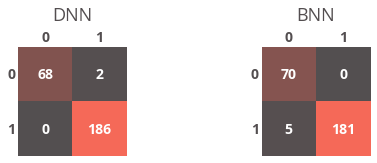

In [ ]:
# Display confusion matrix

fig, ax = plt.subplots(1, 2, figsize=(8, 2))

plot_confusion_matrix(ax[0], sc_metrics_dnn['conf_matrix'], 'dnn')
plot_confusion_matrix(ax[1], sc_metrics_bnn['conf_matrix'], 'bnn')

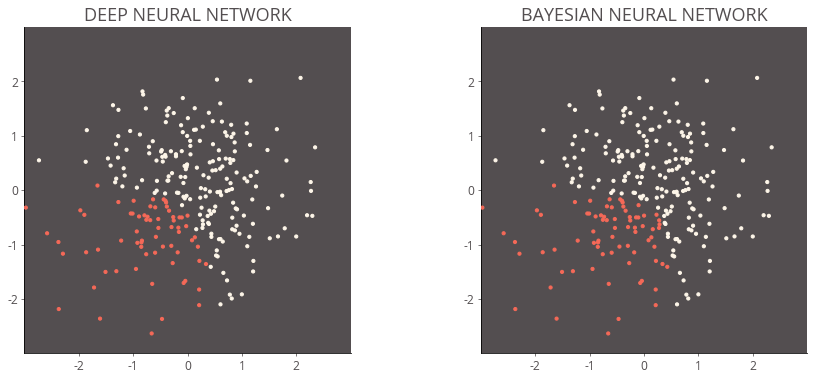

In [ ]:
# Display predictions for test data

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

visualize_xor_data(ax[0], sc_metrics_dnn['test_data'], sc_metrics_dnn['pred_labels'], 
                   'deep neural network')
visualize_xor_data(ax[1], sc_metrics_bnn['test_data'], sc_metrics_bnn['pred_labels'], 
                   'bayesian neural network')

## **Posterior distributions Analysis**

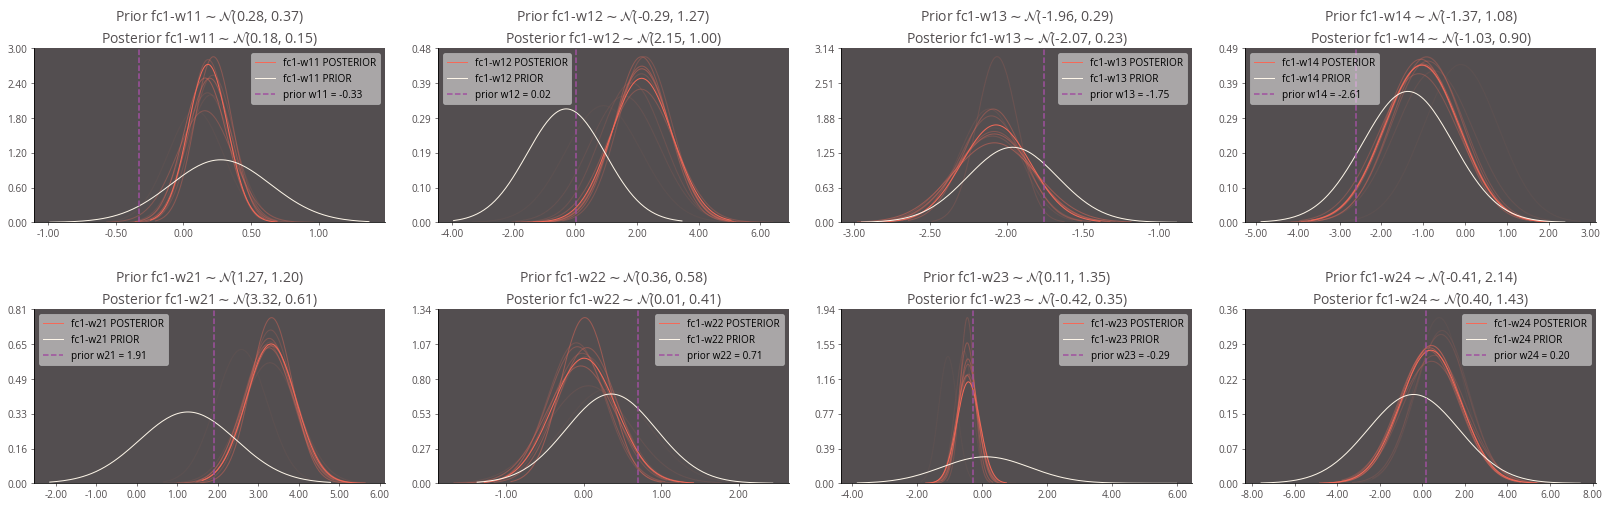

In [ ]:
# FC1 weight

fig, ax = plt.subplots(2, 4, figsize=(28, 8), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        
        prior_name = 'w{:s}'.format(layer[-1])
        loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col, row]
        scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col, row]
        prior_value = sc_fc1_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row, col], param_name, 
                              loc_post, scale_post, 
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

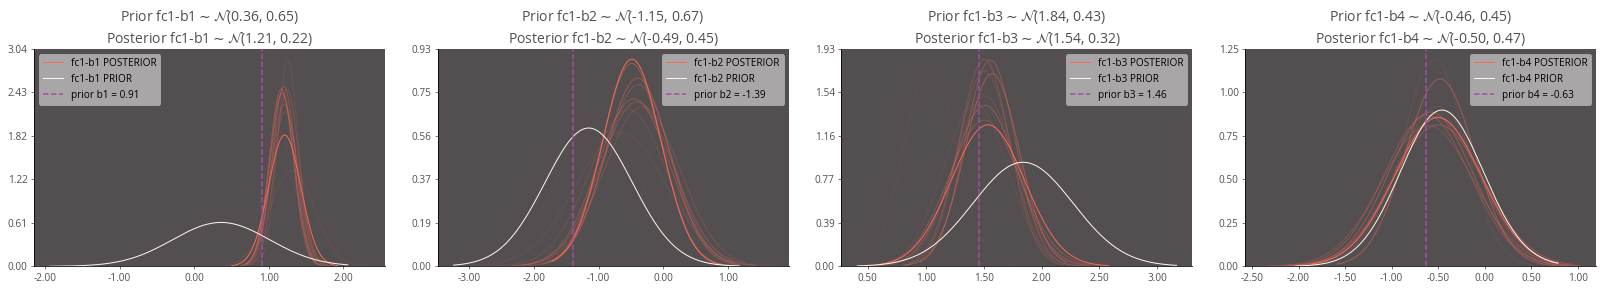

In [ ]:
# FC1 bias

fig, ax = plt.subplots(1, 4, figsize=(28, 4), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
        
    prior_name = 'b{:s}'.format(layer[-1])
    loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col]
    scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col]
    prior_value = sc_fc1_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax[col], param_name, 
                          loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

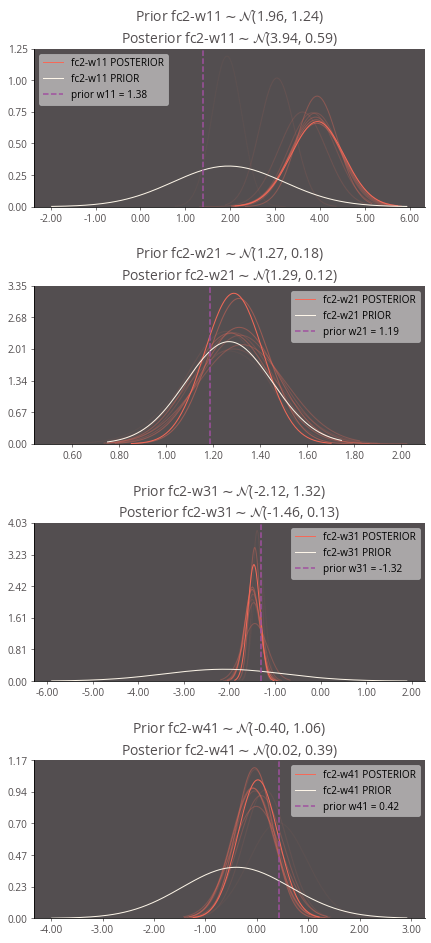

In [ ]:
# FC2 weight

fig, ax = plt.subplots(4, 1, figsize=(7, 16), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        
        prior_name = 'w{:s}'.format(layer[-1])
        loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col, row]
        scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col, row]
        prior_value = sc_fc2_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row], param_name, 
                              loc_post, scale_post,
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

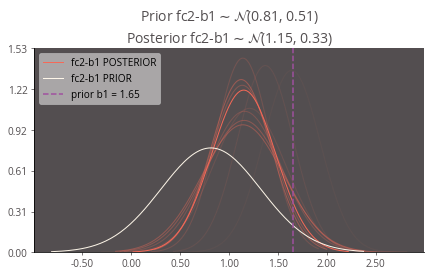

In [ ]:
# FC2 bias

fig, ax = plt.subplots(1, 1, figsize=(7, 3.75), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
        
    prior_name = 'b{:s}'.format(layer[-1])
    loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col]
    scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col]
    prior_value = sc_fc2_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax, param_name, 
                          loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

# **Sanity Check 6**


Data labeled using random initialization for the weights and biases distributions parameters
> $\mu_{_{SC}} \sim \mathcal{N}(0, 1) + c$  ,  where $c \sim \mathcal{U}(0, 1)$  
> $\sigma_{_{SC}} \sim \mathcal{N}(0, 1) $  
> $w, b \sim \mathcal{N}(\mu_{_{SC}}, \sigma_{_{SC}})$



In [ ]:
# Generate sanity-check data

def generate_labels(data):
    c = torch.rand(1)
    w1_loc = torch.randn(4, 2).float().T + c
    w1_scale = torch.abs(torch.randn(4, 2).float().T)
    w1_dist = torch.distributions.Normal(loc=w1_loc, scale=w1_scale)
    fc1_weight = []
    for _ in range(1):
        fc1_weight.append(w1_dist.sample())
    fc1_weight = torch.stack(fc1_weight)
    fc1_weight = fc1_weight.mean(dim=0)

    b1_loc = torch.randn(4).float() + c
    b1_scale = torch.abs(torch.randn(4).float())
    b1_dist = torch.distributions.Normal(loc=b1_loc, scale=b1_scale)
    fc1_bias = []
    for _ in range(1):
        fc1_bias.append(b1_dist.sample())
    fc1_bias = torch.stack(fc1_bias)
    fc1_bias = fc1_bias.mean(dim=0)
    
    w2_loc = torch.randn(1, 4).float().T + c
    w2_scale = torch.abs(torch.randn(1, 4).float().T)
    w2_dist = torch.distributions.Normal(loc=w2_loc, scale=w2_scale)
    fc2_weight = []
    for _ in range(1):
        fc2_weight.append(w2_dist.sample())
    fc2_weight = torch.stack(fc2_weight)
    fc2_weight = fc2_weight.mean(dim=0)

    b2_loc = torch.randn(1).float() + c
    b2_scale = torch.abs(torch.randn(1).float())
    b2_dist = torch.distributions.Normal(loc=b2_loc, scale=b2_scale)
    fc2_bias = []
    for _ in range(1):
        fc2_bias.append(b2_dist.sample())
    fc2_bias = torch.stack(fc2_bias)
    fc2_bias = fc2_bias.mean(dim=0)

    labels = torch.matmul(data, fc1_weight) + fc1_bias
    labels = F.relu(labels)
    labels = torch.matmul(labels, fc2_weight) + fc2_bias
    labels = F.sigmoid(labels).squeeze()
    labels = (labels > .5).float()

    priors_dict = {'w1_loc': w1_loc, 'w1_scale': w1_scale,
                   'b1_loc': b1_loc, 'b1_scale': b1_scale,
                   'w2_loc': w2_loc, 'w2_scale': w2_scale,
                   'b2_loc': b2_loc, 'b2_scale': b2_scale}

    return priors_dict, fc1_weight, fc1_bias, fc2_weight, fc2_bias, labels

fc1_weight = 
 tensor([[-0.2633, -1.3027,  1.2130,  1.4779],
        [-2.8891, -2.6833,  2.2057, -0.4316]])

fc1_bias = 
 tensor([ 3.6837,  0.3759,  1.7647, -0.5371])

fc2_weight = 
 tensor([[ 0.7394],
        [-0.1461],
        [-0.7296],
        [ 2.3242]])

fc2_bias = 
 tensor([-1.0099])


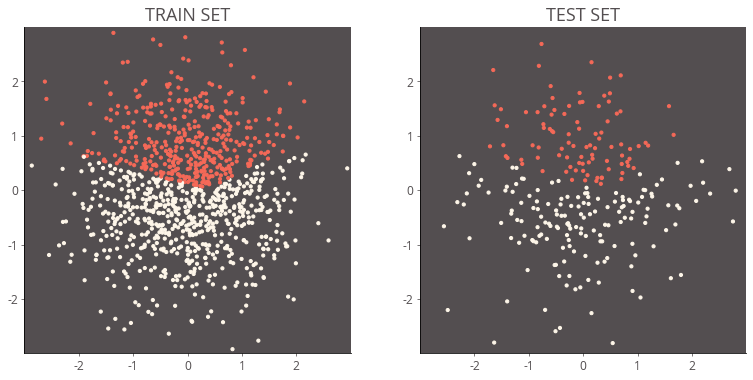

In [ ]:
# Create train and test sets

sc_data = torch.randn(1280, 2)
sc_priors_dict, sc_fc1_weight, sc_fc1_bias, sc_fc2_weight, sc_fc2_bias, sc_labels = generate_labels(sc_data)

print('fc1_weight = \n', sc_fc1_weight)
print('\nfc1_bias = \n', sc_fc1_bias)
print('\nfc2_weight = \n', sc_fc2_weight)
print('\nfc2_bias = \n', sc_fc2_bias)
# print('\n\n')

sc_train_data, sc_train_labels = sc_data[:1024], sc_labels[:1024]
sc_test_data, sc_test_labels = sc_data[1024:], sc_labels[1024:]
# print('Train Set : %4d samples - %s' % (len(sc_train_data), str(sc_train_data.shape)))
# print(' Test Set : %4d samples - %s' % (len(sc_test_data), str(sc_test_data.shape)))
# print('\n\n')

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
visualize_xor_data(ax[0], sc_train_data, sc_train_labels.int(), 'train set')
visualize_xor_data(ax[1], sc_test_data, sc_test_labels.int(), 'test set')

In [ ]:
# Creating Dataloaders

sc_train_dataset = TensorDataset(sc_train_data, sc_train_labels)
sc_test_dataset = TensorDataset(sc_test_data, sc_test_labels)

sc_train_loader = DataLoader(sc_train_dataset, batch_size=128, drop_last=True)
sc_test_loader = DataLoader(sc_test_dataset, batch_size=128, drop_last=True)

print('Train batches : %d' % len(sc_train_loader))
print(' Test batches : %d' % len(sc_test_loader))

Train batches : 8
 Test batches : 2


### **Models**

In [ ]:
class DNN(nn.Module):
    def __init__(self, in_size, hid_size, out_size):
        super().__init__()

        self._fc1 = nn.Linear(in_size, hid_size)
        self._fc2 = nn.Linear(hid_size, out_size)

    def forward(self, x):

        x = self._fc1(x)
        x = F.relu(x)
        x = self._fc2(x)
        x = F.sigmoid(x)

        return x

In [ ]:
class BNN(nn.Module):
    def __init__(self, model_dnn, in_size, hid_size, out_size):
        super().__init__()

        self.in_size = in_size
        self.hid_size = hid_size
        self.out_size = out_size
        self.model_dnn = model_dnn

    def model_bnn(self, x, y=None):
        _fc1w_prior = dist.Normal(loc=sc_priors_dict['w1_loc'].T,
                                  scale=sc_priors_dict['w1_scale'].T)
        _fc1b_prior = dist.Normal(loc=sc_priors_dict['b1_loc'].T,
                                  scale=sc_priors_dict['b1_scale'].T)
        
        _fc2w_prior = dist.Normal(loc=sc_priors_dict['w2_loc'].T,
                                  scale=sc_priors_dict['w2_scale'].T)
        _fc2b_prior = dist.Normal(loc=sc_priors_dict['b2_loc'].T,
                                  scale=sc_priors_dict['b2_scale'].T)
        
        priors_dict = {'_fc1.weight': _fc1w_prior,
                    '_fc1.bias': _fc1b_prior,
                    '_fc2.weight': _fc2w_prior,
                    '_fc2.bias': _fc2b_prior}
                    
        sampled_module = pyro.random_module('module', self.model_dnn, priors_dict)  
        sampled_model = sampled_module()
        probs = sampled_model(x)

        obs = pyro.sample('obs', dist.Bernoulli(probs), obs=y)

    def guide_bnn(self, x, y=None):
        _fc1w_loc = pyro.param('_fc1w_loc', torch.randn(self.hid_size, self.in_size))
        _fc1w_scale = torch.abs(pyro.param('_fc1w_scale', torch.randn(self.hid_size, self.in_size)))
        _fc1w_posterior = dist.Normal(loc=_fc1w_loc, scale=_fc1w_scale)

        _fc1b_loc = pyro.param('_fc1b_loc', torch.randn(self.hid_size))
        _fc1b_scale = torch.abs(pyro.param('_fc1b_scale', torch.randn(self.hid_size)))
        _fc1b_posterior = dist.Normal(loc=_fc1b_loc, scale=_fc1b_scale)

        _fc2w_loc = pyro.param('_fc2w_loc', torch.randn(self.out_size, self.hid_size))
        _fc2w_scale = torch.abs(pyro.param('_fc2w_scale', torch.randn(self.out_size, self.hid_size)))
        _fc2w_posterior = dist.Normal(loc=_fc2w_loc, scale=_fc2w_scale)
        
        _fc2b_loc = pyro.param('_fc2b_loc', torch.randn(self.out_size))
        _fc2b_scale = torch.abs(pyro.param('_fc2b_scale', torch.randn(self.out_size)))
        _fc2b_posterior = dist.Normal(loc=_fc2b_loc, scale=_fc2b_scale)
        
        posteriors_dict = {'_fc1.weight': _fc1w_posterior,
                    '_fc1.bias': _fc1b_posterior,
                    '_fc2.weight': _fc2w_posterior,
                    '_fc2.bias': _fc2b_posterior}
        
        sampled_module = pyro.random_module('module', self.model_dnn, posteriors_dict) 
        
        return sampled_module()

In [ ]:
# Define parameters and Initialize model

sc_model_dnn = DNN(2, 4, 1)

optimizer_dnn = torch.optim.Adam(sc_model_dnn.parameters(),
                                 lr=.001, weight_decay=.01) 
criterion_dnn = nn.BCELoss()

sc_model_bdnn = DNN(2, 4, 1)
sc_bnn_ = BNN(sc_model_bdnn, 2, 4, 1)

optimizer_bnn = pyro.optim.Adam({'lr': .01})
svi = SVI(sc_bnn_.model_bnn, sc_bnn_.guide_bnn, optimizer_bnn, loss=Trace_ELBO())

In [ ]:
# Training process

sc_train_data_dnn = {'train_loss': [], 'train_acc': []}
sc_train_data_bnn = {'train_loss': [], 'train_acc': []}

log_interval = 100
num_epochs = 1000

pyro.clear_param_store()
for epoch in range(num_epochs):

    train_loss_dnn, train_acc_dnn = train_dnn(sc_model_dnn, sc_train_loader, 
                                              criterion_dnn, optimizer_dnn, epoch)
    train_loss_bnn, train_acc_bnn = train_bnn(sc_train_loader, svi, epoch)
    
    sc_train_data_dnn['train_loss'].append(train_loss_dnn)
    sc_train_data_dnn['train_acc'].append(train_acc_dnn)

    sc_train_data_bnn['train_loss'].append(train_loss_bnn)
    sc_train_data_bnn['train_acc'].append(train_acc_bnn)

    if epoch == 0:        
        inter_params_store = {key: [] for key in pyro.get_param_store()}

    if (epoch+1) % log_interval == 0 or epoch == 0 or (epoch+1) == num_epochs:
        print('\nEPOCH {:>2d}'.format(epoch+1))
        print('   DNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_dnn,
                                                               train_acc_dnn))
        print('   BNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_bnn,
                                                               train_acc_bnn))
        
        inter_ps =  pyro.get_param_store()
        for key, param in inter_ps.items():
            inter_params_store[key].append(param.detach().clone())


EPOCH  1
   DNN loss:    0.6945468   |   acc: 0.5439453
   BNN loss:  870.7577263   |   acc: 0.5869141

EPOCH 100
   DNN loss:    0.2058926   |   acc: 0.9804688
   BNN loss:   49.6691957   |   acc: 0.9619141

EPOCH 200
   DNN loss:    0.1353679   |   acc: 0.9746094
   BNN loss:   34.4192639   |   acc: 0.9765625

EPOCH 300
   DNN loss:    0.1177120   |   acc: 0.9804688
   BNN loss:   32.4521108   |   acc: 0.9775391

EPOCH 400
   DNN loss:    0.1117744   |   acc: 0.9843750
   BNN loss:   31.8409031   |   acc: 0.9794922

EPOCH 500
   DNN loss:    0.1093840   |   acc: 0.9853516
   BNN loss:   29.4665914   |   acc: 0.9775391

EPOCH 600
   DNN loss:    0.1087819   |   acc: 0.9843750
   BNN loss:   27.7229889   |   acc: 0.9726562

EPOCH 700
   DNN loss:    0.1086011   |   acc: 0.9843750
   BNN loss:   28.2205676   |   acc: 0.9716797

EPOCH 800
   DNN loss:    0.1085154   |   acc: 0.9843750
   BNN loss:   26.6473448   |   acc: 0.9755859

EPOCH 900
   DNN loss:    0.1084963   |   acc: 0.984375

In [ ]:
ps =  pyro.get_param_store()
sc_params_store = dict()
for key, param in ps.items():
    sc_params_store[key] = param.detach().clone()

### **Performance**

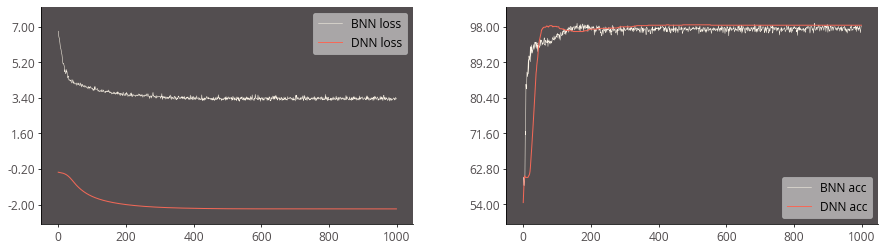

In [ ]:
# Display loss and accuracy

fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={'hspace': .5,
                                                          'wspace': .25})
  
train_loss_bnn = np.log(np.array(sc_train_data_bnn['train_loss']))
train_loss_dnn = np.log(np.array(sc_train_data_dnn['train_loss']))
plot_loss(ax[0], train_loss_bnn, train_loss_dnn)

train_acc_bnn = np.array(sc_train_data_bnn['train_acc'])*100
train_acc_dnn = np.array(sc_train_data_dnn['train_acc'])*100
plot_accuracies(ax[1], train_acc_bnn, train_acc_dnn)

In [ ]:
# Compute performance metrics

print('DEEP NEURAL NETWORK')
print('-' * 64)
sc_metrics_dnn = compute_performance_dnn(sc_model_dnn, sc_test_loader)

print('\n\nBAYESIAN NEURAL NETWORK')
print('-' * 64)
sc_metrics_bnn = compute_performance_bnn(sc_bnn_.guide_bnn, sc_test_loader)

DEEP NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        95
           1       0.99      0.99      0.99       161

    accuracy                           0.99       256
   macro avg       0.99      0.99      0.99       256
weighted avg       0.99      0.99      0.99       256



BAYESIAN NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        95
           1       0.99      0.98      0.99       161

    accuracy                           0.98       256
   macro avg       0.98      0.99      0.98       256
weighted avg       0.98      0.98      0.98       256



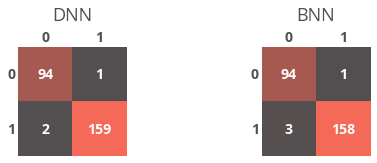

In [ ]:
# Display confusion matrix

fig, ax = plt.subplots(1, 2, figsize=(8, 2))

plot_confusion_matrix(ax[0], sc_metrics_dnn['conf_matrix'], 'dnn')
plot_confusion_matrix(ax[1], sc_metrics_bnn['conf_matrix'], 'bnn')

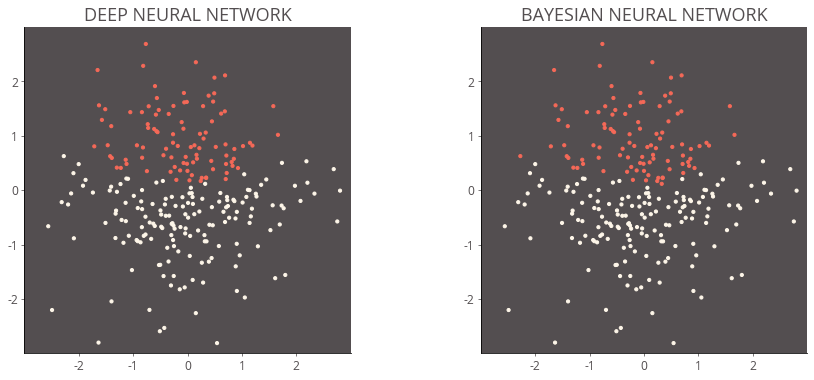

In [ ]:
# Display predictions for test data

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

visualize_xor_data(ax[0], sc_metrics_dnn['test_data'], sc_metrics_dnn['pred_labels'], 
                   'deep neural network')
visualize_xor_data(ax[1], sc_metrics_bnn['test_data'], sc_metrics_bnn['pred_labels'], 
                   'bayesian neural network')

## **Posterior distributions Analysis**

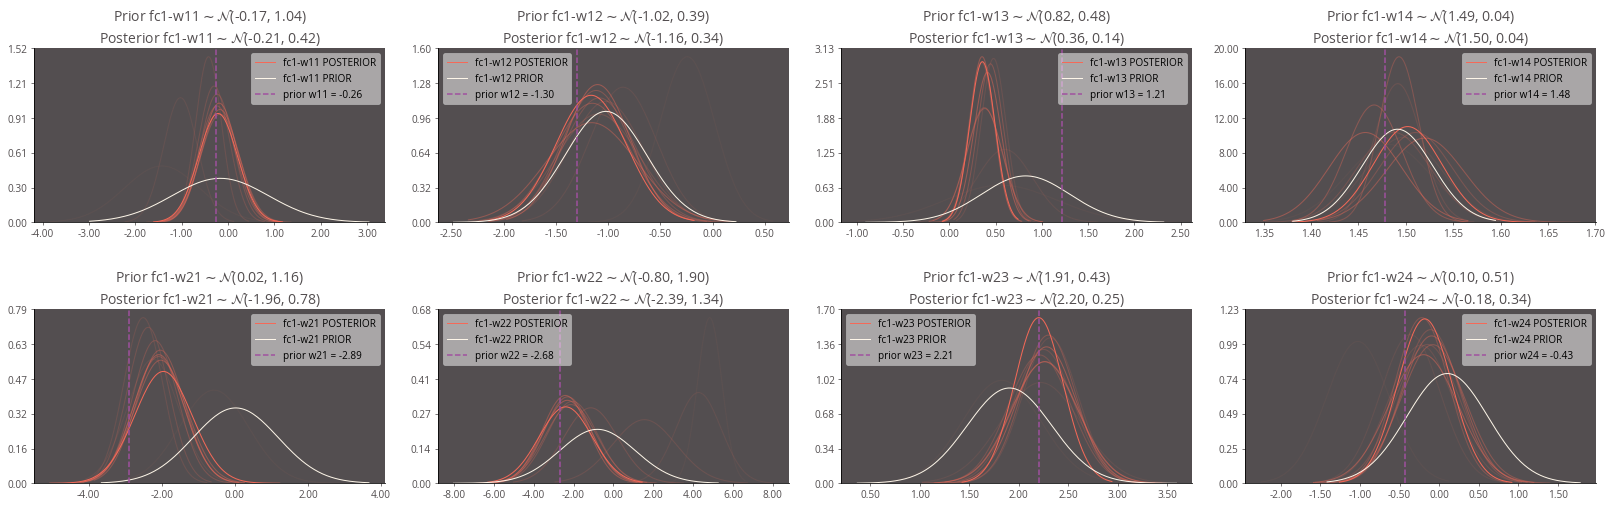

In [ ]:
# FC1 weight

fig, ax = plt.subplots(2, 4, figsize=(28, 8), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        
        prior_name = 'w{:s}'.format(layer[-1])
        loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col, row]
        scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col, row]
        prior_value = sc_fc1_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row, col], param_name, 
                              loc_post, scale_post, 
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

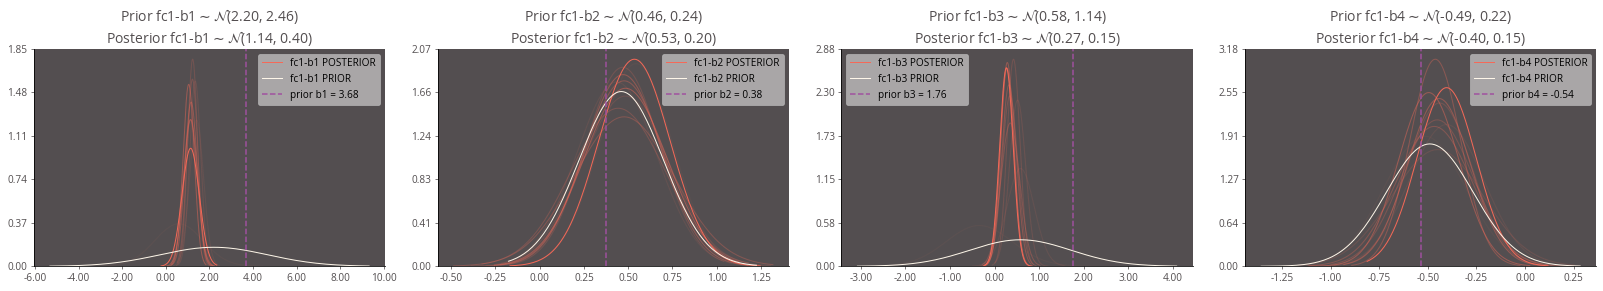

In [ ]:
# FC1 bias

fig, ax = plt.subplots(1, 4, figsize=(28, 4), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
        
    prior_name = 'b{:s}'.format(layer[-1])
    loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col]
    scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col]
    prior_value = sc_fc1_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax[col], param_name, 
                          loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

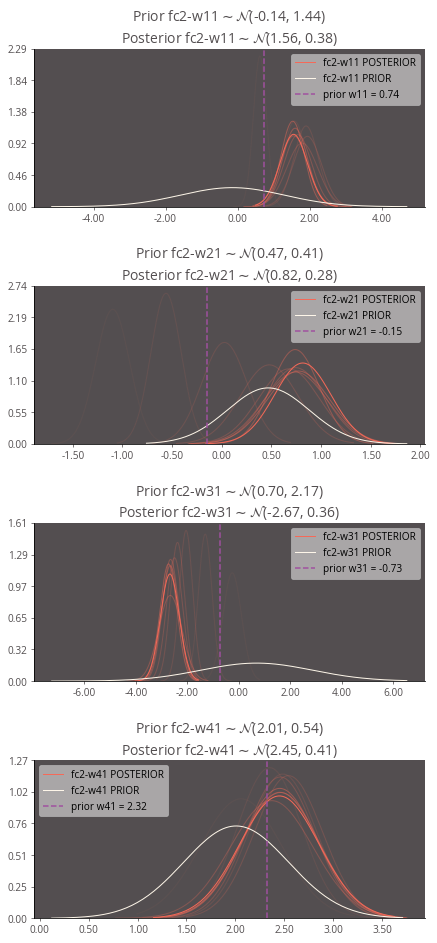

In [ ]:
# FC2 weight

fig, ax = plt.subplots(4, 1, figsize=(7, 16), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        
        prior_name = 'w{:s}'.format(layer[-1])
        loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col, row]
        scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col, row]
        prior_value = sc_fc2_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row], param_name, 
                              loc_post, scale_post,
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

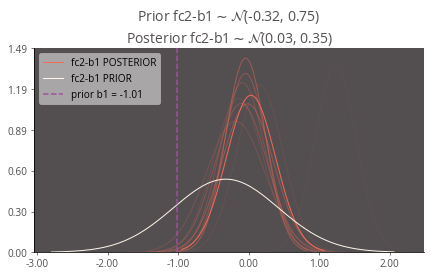

In [ ]:
# FC2 bias

fig, ax = plt.subplots(1, 1, figsize=(7, 3.75), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
        
    prior_name = 'b{:s}'.format(layer[-1])
    loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col]
    scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col]
    prior_value = sc_fc2_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax, param_name, 
                          loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)